In [1]:
import pandas as pd
import collections

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import pickle

import json

import requests

n_clusters = 4

In [2]:
plt.style.use('seaborn')

In [3]:
loans_samples_reduced = pd.read_csv('final_reduced_dataset.csv')

In [4]:
loans_samples_reduced = loans_samples_reduced.set_index('loan_id')

In [5]:
loans_samples_reduced['borrower_count'] = loans_samples_reduced['female_count']+loans_samples_reduced['male_count']

In [6]:
# Stratified Sampling by country and sectors

loans_samples = loans_samples_reduced.groupby(['sector_name'], group_keys=False).apply(lambda x: x.sample(min(len(x), 1200)))

loans_samples = loans_samples.reset_index(drop=True)

loans_samples.shape

(17663, 20)

In [7]:
def getFeatureVector(dataset):
    
    X = dataset[['loan_amount', 'status', 'activity_name', 'sector_name','borrower_count','mpi', 'population_in_mpi',
                 'Education', 'Health', 'Living standards', 'population_in_severe_mpi']]

    dataset_dummies = pd.get_dummies(X)

    scaler = StandardScaler()

    scaler.fit(dataset_dummies)

    data_scaled = scaler.transform(dataset_dummies)

    feature = pd.DataFrame(data_scaled)

    feature.columns = dataset_dummies.columns
    
    return feature

In [8]:
features_df = getFeatureVector(loans_samples)

features_df.head()

,loan_amount,borrower_count,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi,status_funded,activity_name_Agriculture,...,sector_name_Entertainment,sector_name_Food,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale
0,0.100675,-0.240603,-0.820009,-0.904286,0.860352,-0.096158,-0.721802,-0.598792,0.0,-0.093784,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
1,-0.230631,-0.240603,-0.820009,-0.904286,0.860352,-0.096158,-0.721802,-0.598792,0.0,-0.093784,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
2,-1.224549,-0.240603,-0.820009,-0.904286,0.860352,-0.096158,-0.721802,-0.598792,0.0,-0.093784,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
3,0.763288,7.838808,0.344786,0.473537,-1.584214,0.097254,1.409565,-0.070153,0.0,-0.093784,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
4,1.536335,-0.240603,-1.030198,-1.085212,-0.765816,1.886316,-1.249569,-0.924108,0.0,-0.093784,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054


In [9]:
def applyPCA(n,features):
    pca = PCA(n_components=n) #n-dimensional PCA
    principal_df = pd.DataFrame(pca.fit_transform(features))
    
    # Identifying the significant features of final PCA components
    
    PCA_stats = pd.DataFrame(pca.components_,columns=features.columns,index = range(0,n)).transpose()
    print(f"PCA transformation applied with {n} components:")
    print("\nTop 5 features in each principal component")
    print([PCA_stats[c].nlargest(5) for c in PCA_stats])
    print('-----------------------------------------------')
    
    return principal_df

In [10]:
applyPCA(3,features_df)

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.492304
mpi                         0.488584
population_in_severe_mpi    0.461562
Living standards            0.269111
borrower_count              0.141608
Name: 0, dtype: float64, sector_name_Personal Use                   0.330686
Education                                  0.327382
activity_name_Home Appliances              0.290038
sector_name_Housing                        0.193768
activity_name_Personal Housing Expenses    0.192694
Name: 1, dtype: float64, sector_name_Personal Use         0.479140
activity_name_Home Appliances    0.399759
borrower_count                   0.279923
sector_name_Health               0.184121
activity_name_Home Energy        0.176108
Name: 2, dtype: float64]
-----------------------------------------------


,0,1,2
0,-1.118876,0.586880,0.986720
1,-1.875138,0.950050,0.836826
2,-1.868832,1.156496,0.945478
3,1.765996,0.370157,3.566814
4,-2.240192,-1.249206,1.409141
5,-1.407679,0.750706,1.205225
6,-0.017419,0.527303,0.976011
7,1.811607,0.017170,1.249589
8,-1.413285,0.567198,1.108646
9,0.743454,-0.211000,0.920166


In [11]:
# Assuming 3 components on PCA - plot the clusters

def plotClusters(n,transformed):
    
    colors = ['#2f7ed8', '#0d233a', '#8bbc21', '#910000', '#1aadce', '#492970', '#f28f43', '#77a1e5', '#c42525', '#a6c96a']
    
    
    
    for i in range(n): 
        
        plt.title('View in pair of 2 Dimensions')
        
        ax = plt.subplot(1,3,1)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,2)
        ax.scatter(transformed[transformed['y']==i][1],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,3)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
   
    
    fig = plt.figure(figsize=(8,8))
    ax = p3.Axes3D(fig)
    
    for i in range(n):
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2], 
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
        
    plt.title('View in 3 Dimensions')
    
    
    plt.legend()
    plt.show()


In [12]:
# Sticking with 3 component PCA to help visualize the clusters

pca_transformed = applyPCA(3,features_df)

all_cluster_stats = pd.DataFrame()    

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.492411
mpi                         0.488711
population_in_severe_mpi    0.461738
Living standards            0.268914
borrower_count              0.141522
Name: 0, dtype: float64, sector_name_Personal Use                   0.329242
Education                                  0.320271
activity_name_Home Appliances              0.287599
sector_name_Housing                        0.168645
activity_name_Personal Housing Expenses    0.167883
Name: 1, dtype: float64, sector_name_Personal Use         0.452478
activity_name_Home Appliances    0.377010
borrower_count                   0.267165
sector_name_Health               0.180278
Health                           0.172160
Name: 2, dtype: float64]
-----------------------------------------------


In [13]:
k_silhouette_scores = []

k_interia_scores = []

for k in range(2,10):
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_transformed)

    label = kmeans.labels_

    print(f"\nCluster sizes of {k} clusters: \n\t {collections.Counter(label)}")
   
    silhouette_avg = silhouette_score(pca_transformed, label)
    inertia_value = (kmeans.inertia_/k)
    
    k_silhouette_scores.append(silhouette_avg)
    k_interia_scores.append(inertia_value)
    
    print("\nThe average silhouette_score is :", silhouette_avg,
          "\nThe mean intra cluster distance is :", inertia_value)



Cluster sizes of 2 clusters: 
	 Counter({0: 10030, 1: 7633})

The average silhouette_score is : 0.324281306547 
The mean intra cluster distance is : 51298.9612804

Cluster sizes of 3 clusters: 
	 Counter({1: 9641, 0: 6761, 2: 1261})

The average silhouette_score is : 0.382229869455 
The mean intra cluster distance is : 23659.8137525

Cluster sizes of 4 clusters: 
	 Counter({0: 7484, 1: 6434, 2: 2485, 3: 1260})

The average silhouette_score is : 0.431444707823 
The mean intra cluster distance is : 11532.1756845

Cluster sizes of 5 clusters: 
	 Counter({1: 6045, 3: 5838, 4: 2443, 0: 2080, 2: 1257})

The average silhouette_score is : 0.392100545162 
The mean intra cluster distance is : 7491.59957321

Cluster sizes of 6 clusters: 
	 Counter({2: 5797, 5: 4368, 4: 2346, 0: 2230, 1: 1667, 3: 1255})

The average silhouette_score is : 0.371328512437 
The mean intra cluster distance is : 5436.64897237

Cluster sizes of 7 clusters: 
	 Counter({2: 3488, 4: 3376, 1: 3291, 6: 2616, 3: 1934, 5: 1704

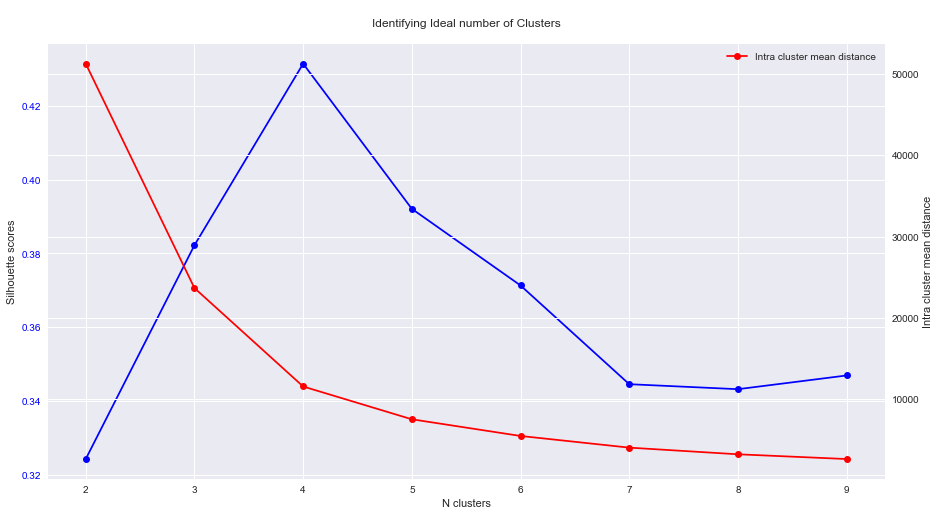

In [14]:


plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 1, 1)

ax1.plot(range(2,10),k_silhouette_scores,marker='o',color='blue', label='Silhouette scores')

ax1.set_xlabel('N clusters')
ax1.set_ylabel('Silhouette scores')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()

ax2.plot(range(2,10),k_interia_scores,marker='o',color='red', label='Intra cluster mean distance')
ax2.set_ylabel('Intra cluster mean distance', )

plt.title('\nIdentifying Ideal number of Clusters\n')

plt.savefig('Identifying_optimal_K.png')


plt.legend()
plt.show()

PCA transformation applied with 4 components:

Top 5 features in each principal component
[population_in_mpi           0.494179
mpi                         0.490418
population_in_severe_mpi    0.463250
Living standards            0.269105
borrower_count              0.142061
Name: 0, dtype: float64, Health                   0.274627
sector_name_Health       0.255565
sector_name_Education    0.238382
sector_name_Clothing     0.223172
loan_amount              0.209412
Name: 1, dtype: float64, sector_name_Personal Use         0.484651
activity_name_Home Appliances    0.400282
borrower_count                   0.277959
activity_name_Home Energy        0.187690
sector_name_Health               0.186175
Name: 2, dtype: float64, sector_name_Arts                        0.284335
sector_name_Education                   0.214315
sector_name_Manufacturing               0.188123
activity_name_Embroidery                0.185907
activity_name_Higher education costs    0.181962
Name: 3, dtype: float64]

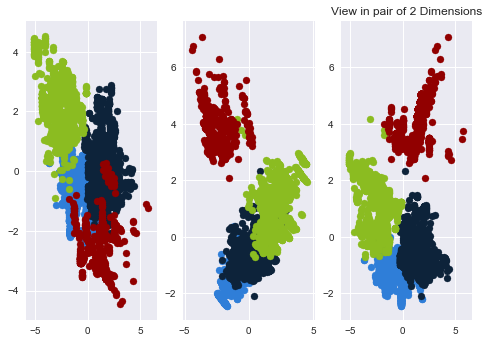

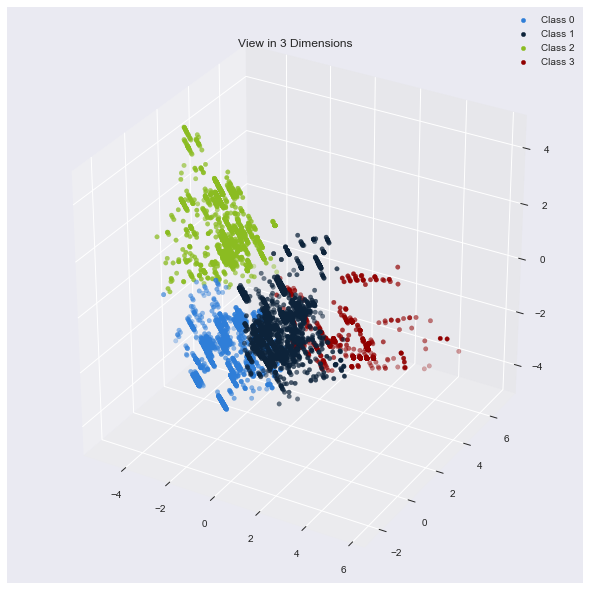


Test Sample


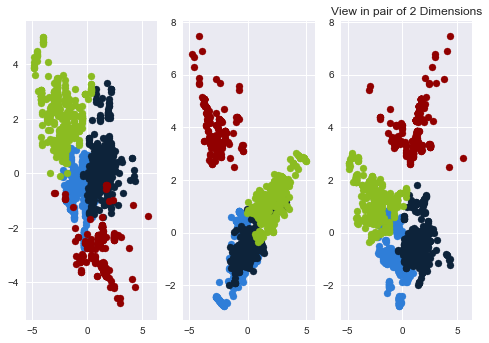

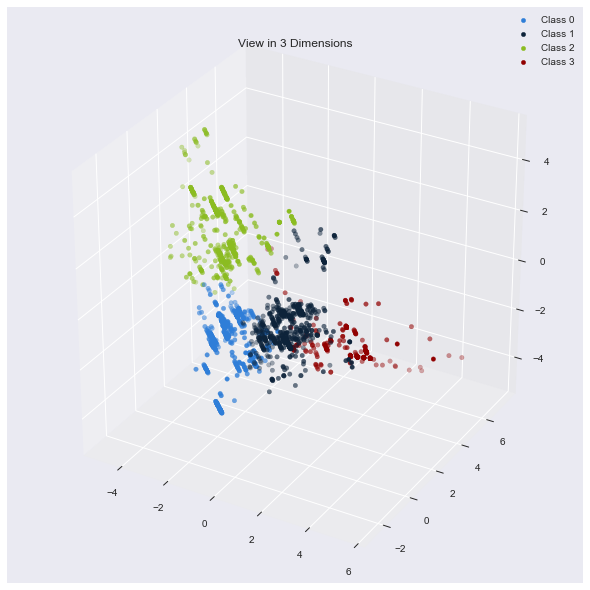

C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Training Sample - Describing categorical

-----------------------------------------------


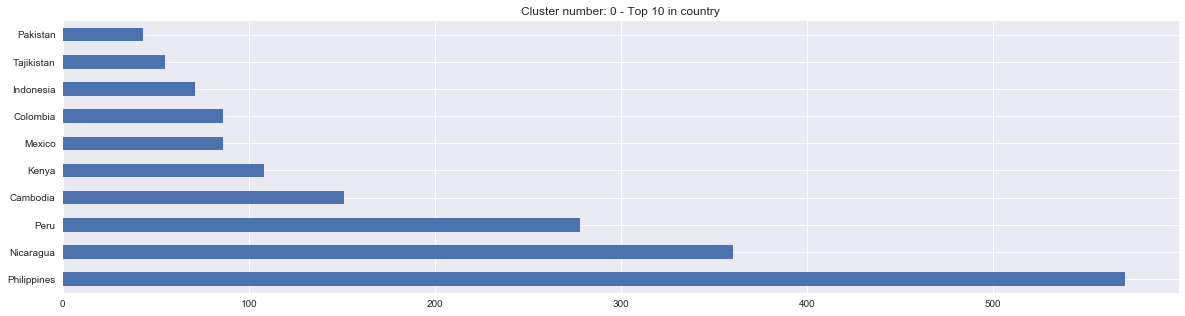

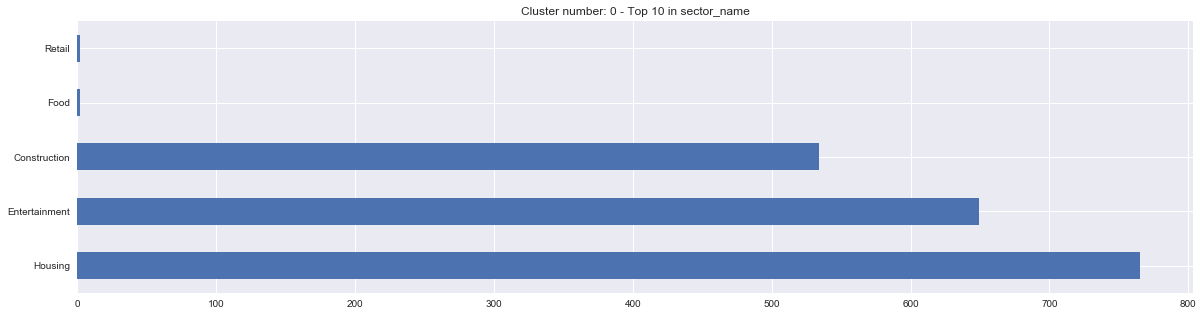

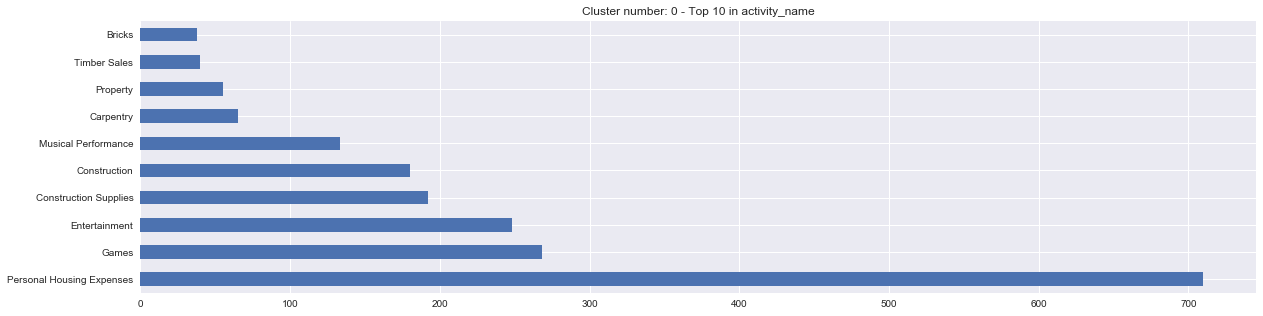

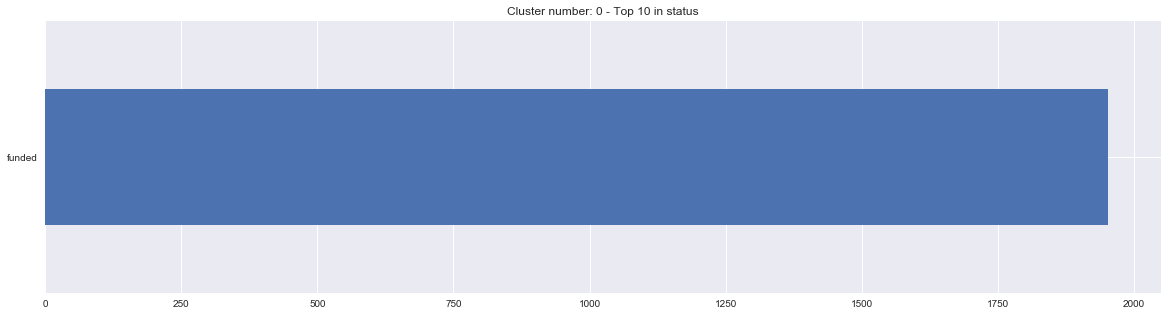

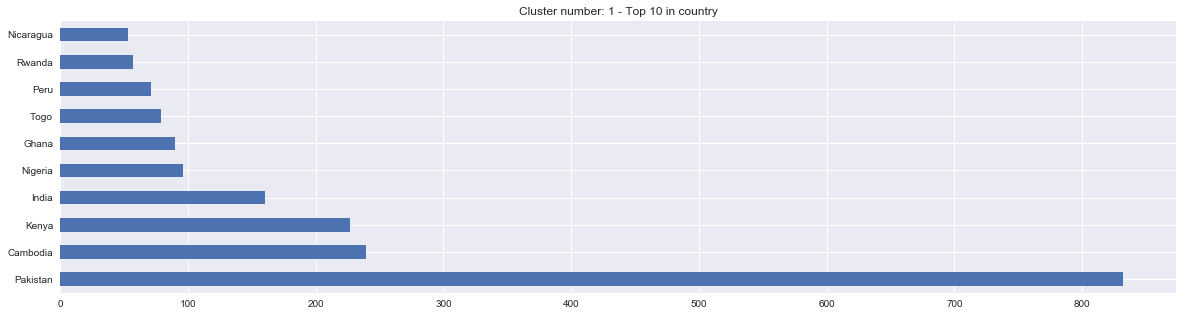

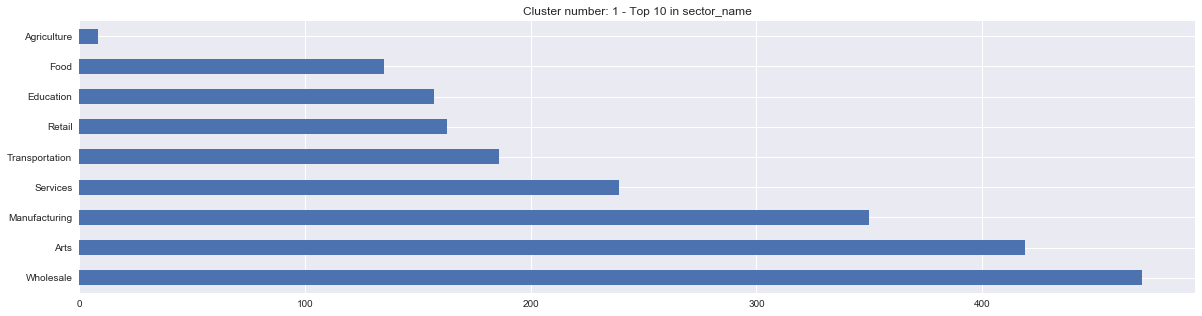

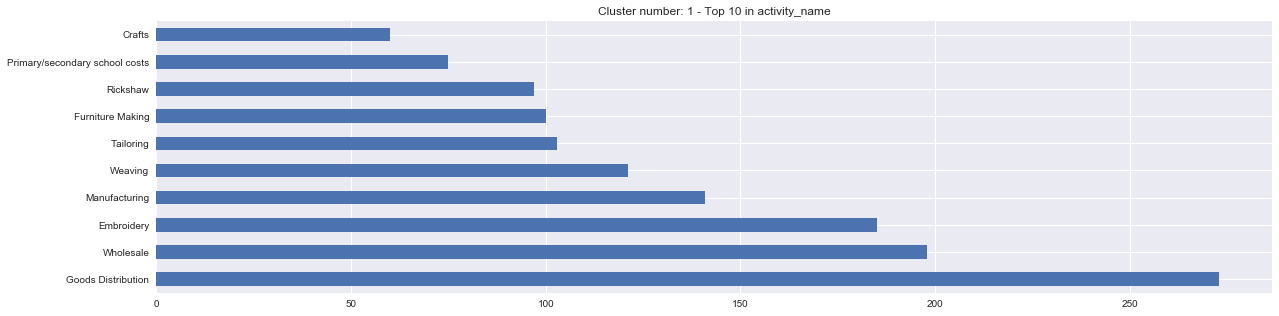

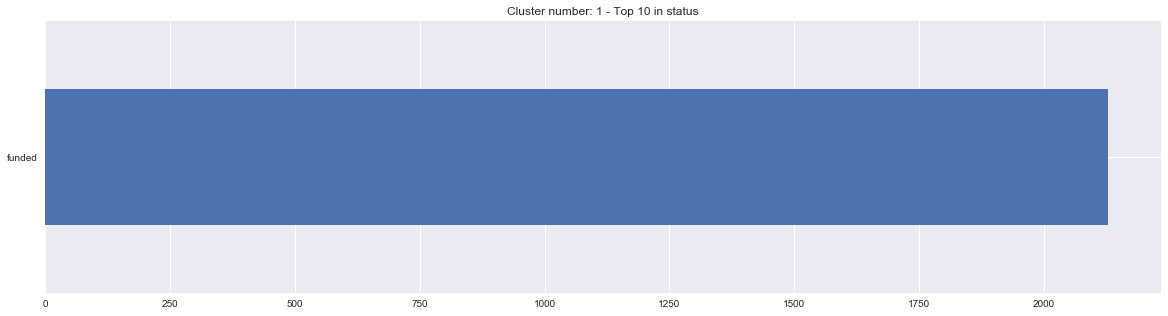

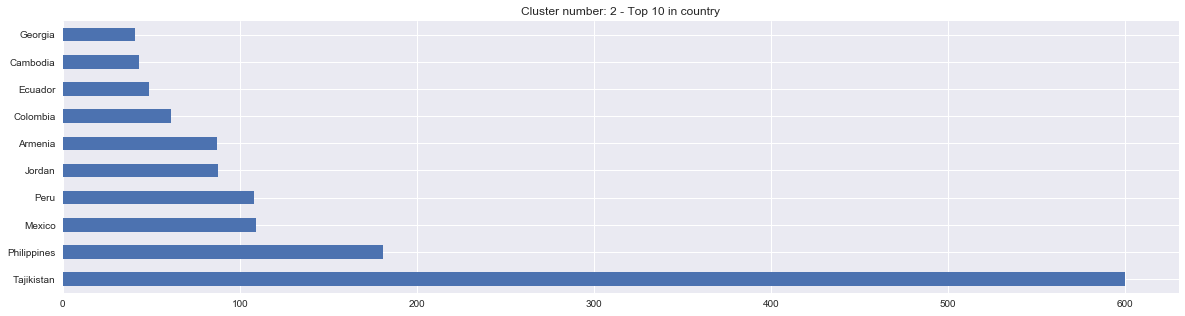

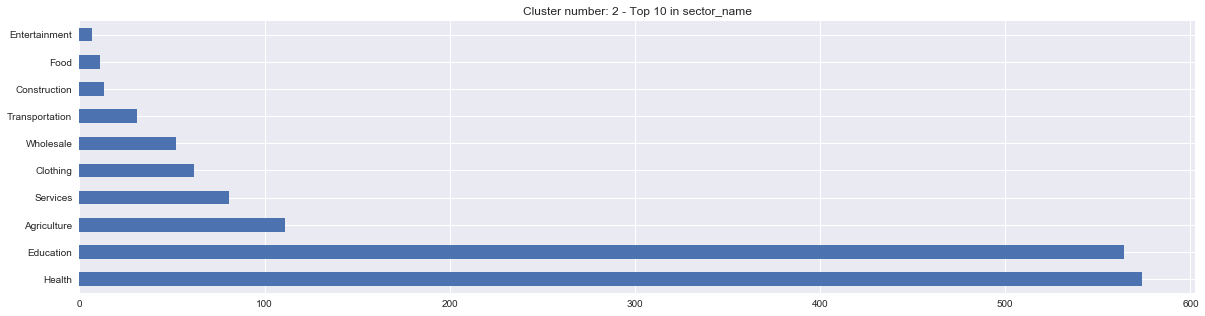

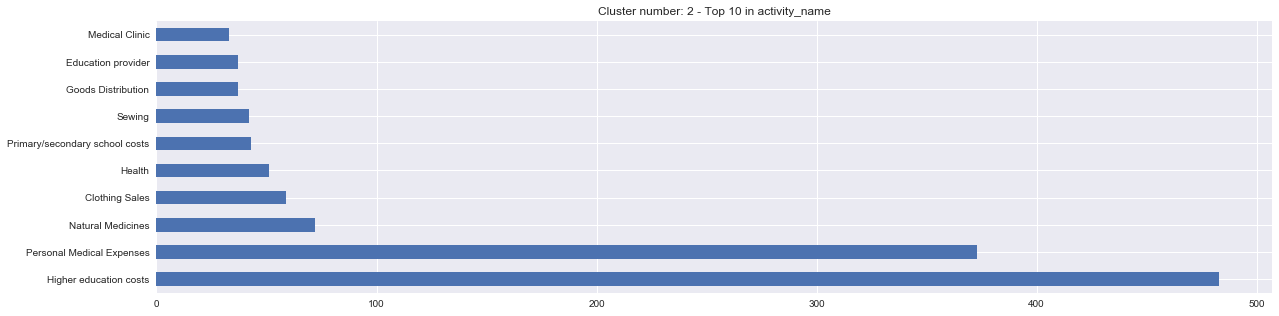

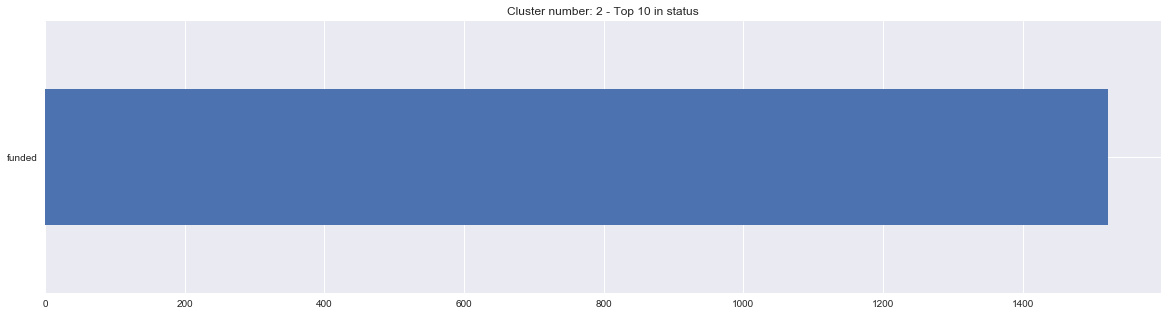

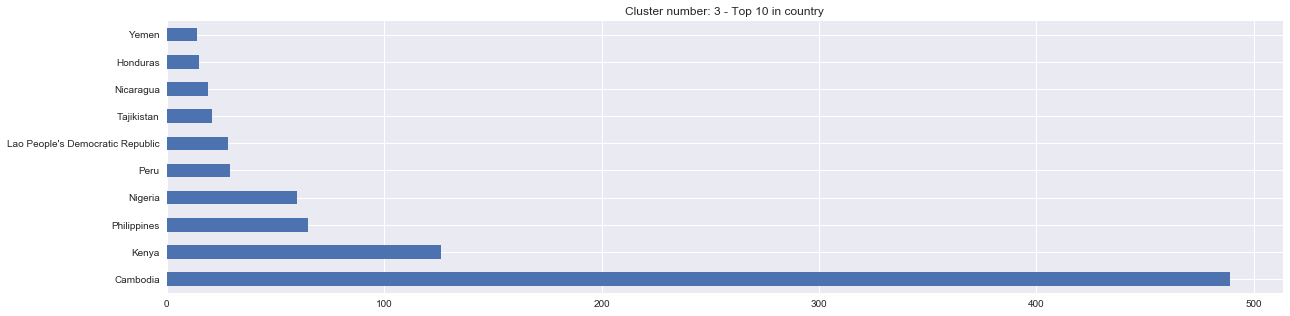

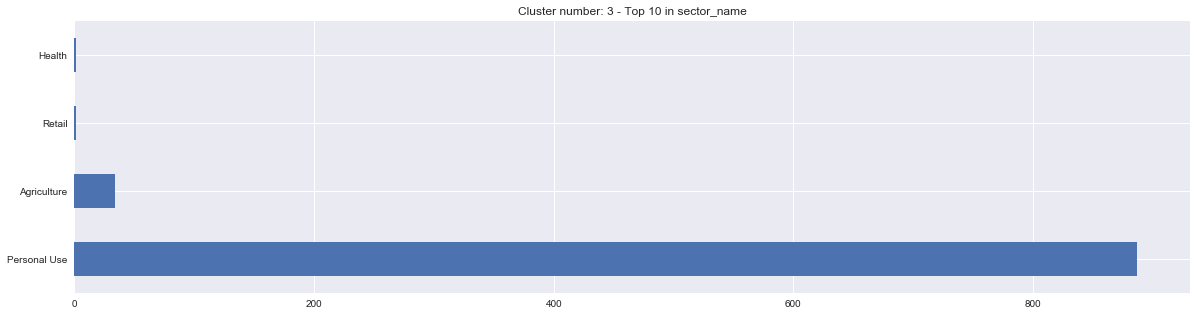

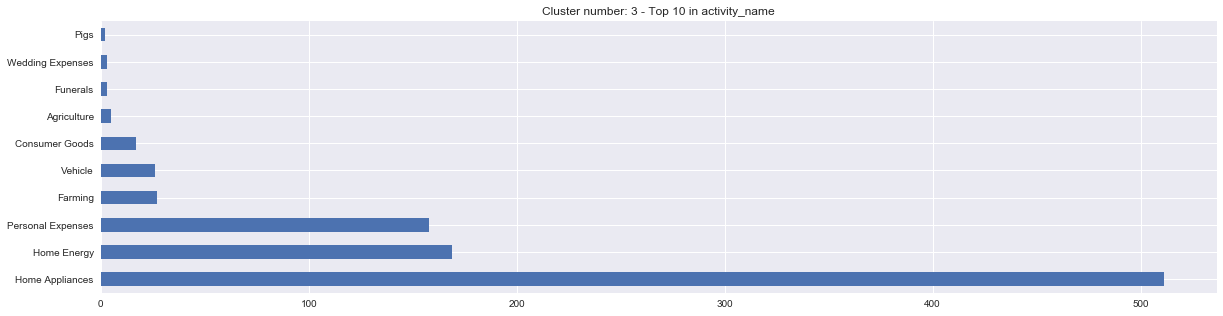

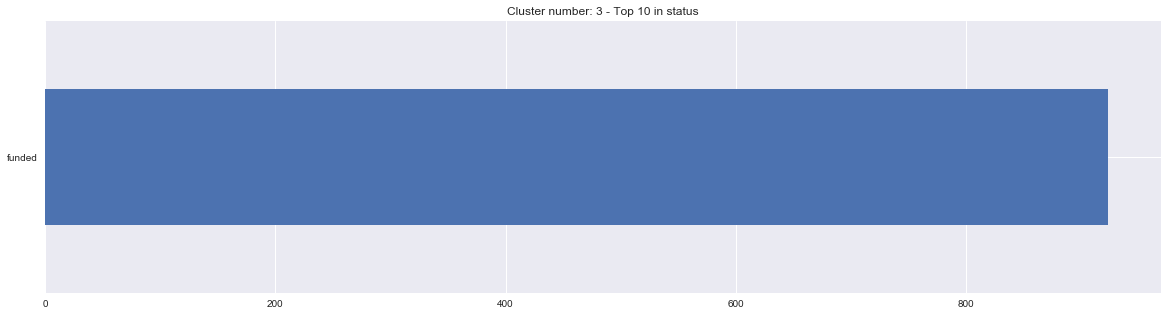


Test Sample - Describing categorical

-----------------------------------------------


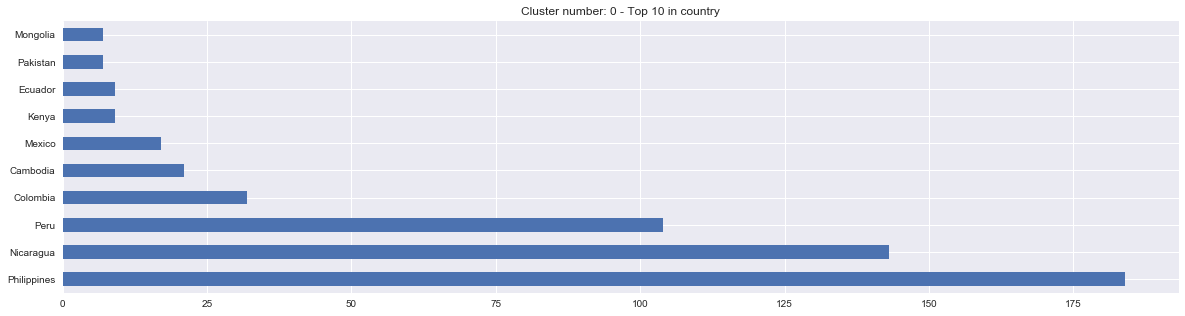

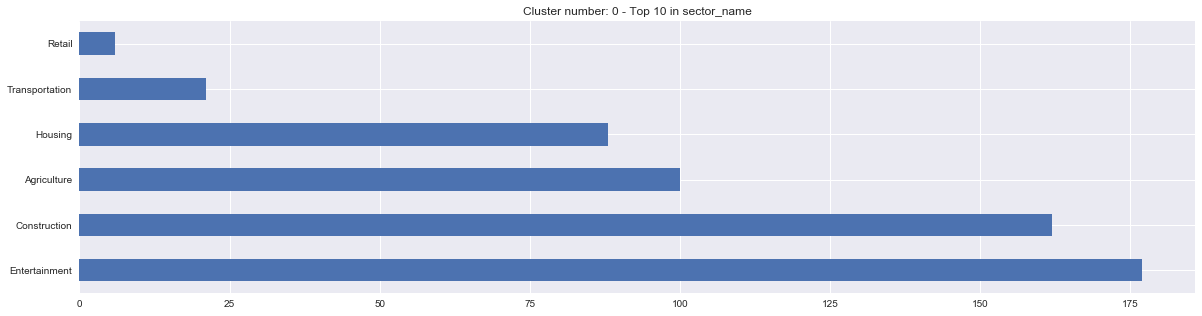

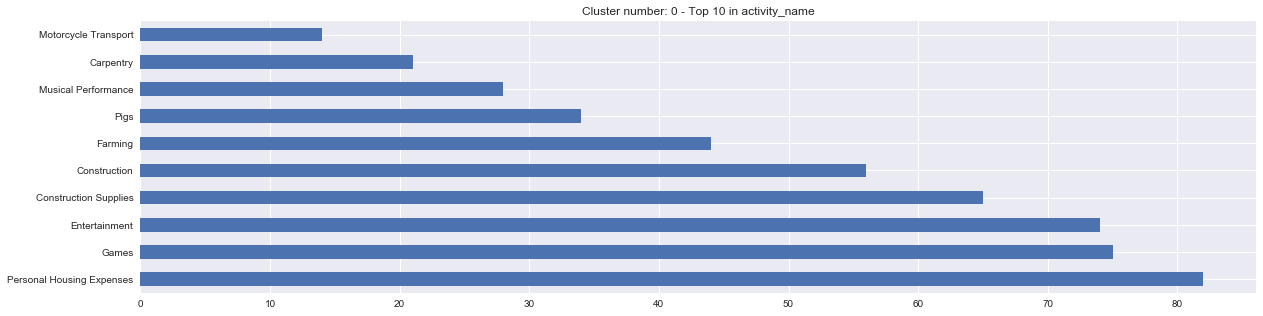

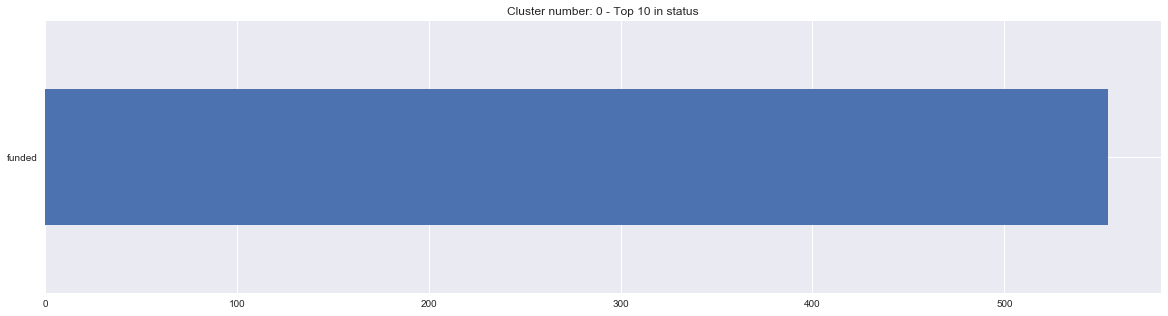

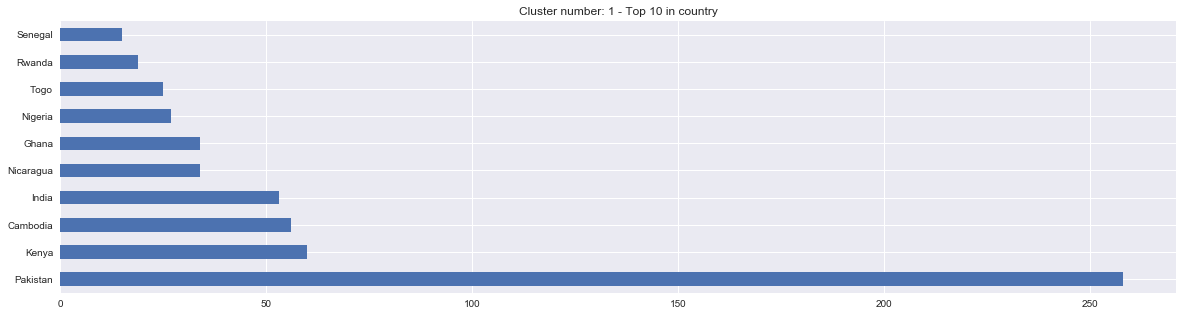

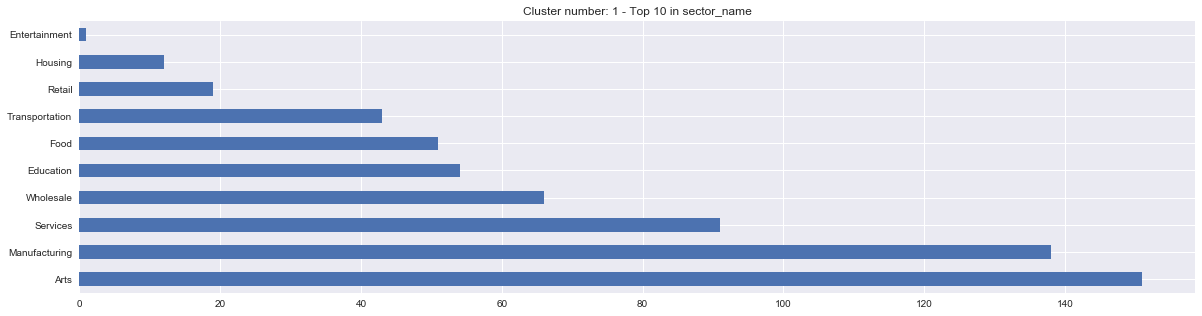

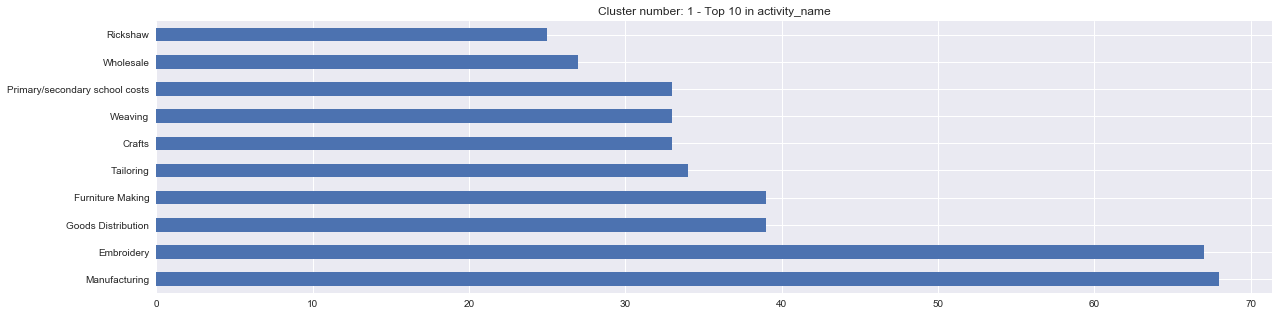

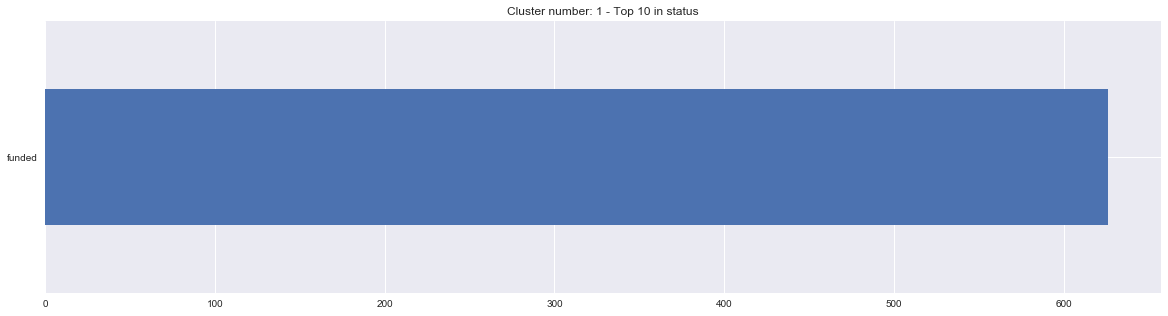

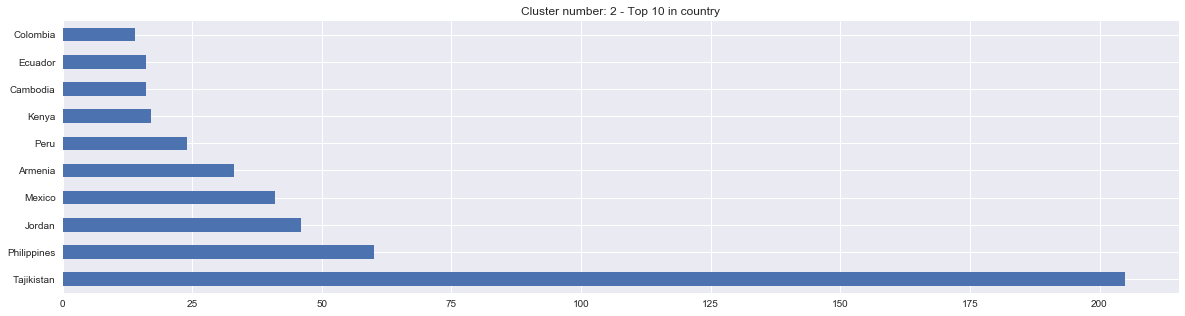

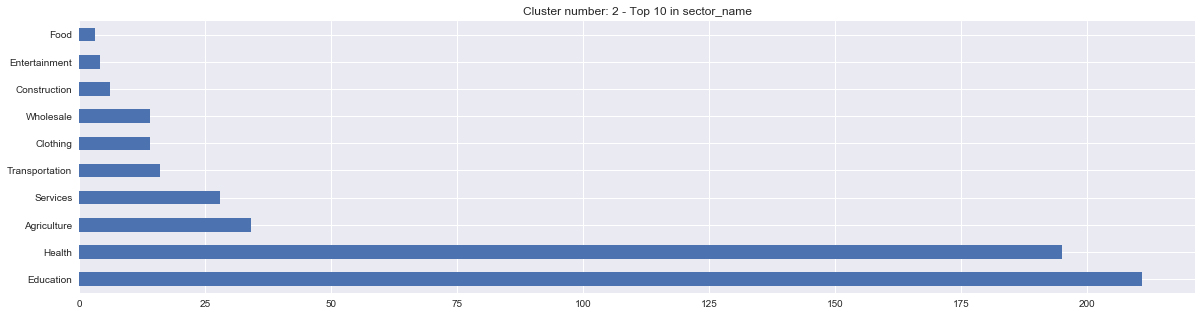

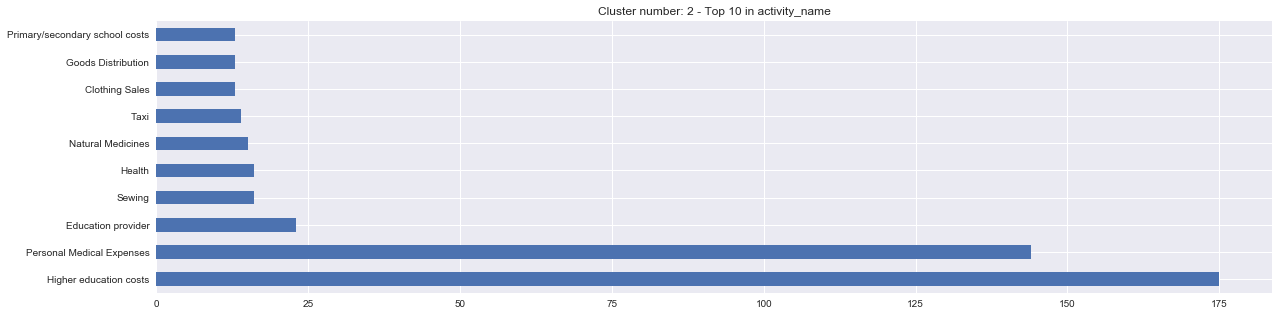

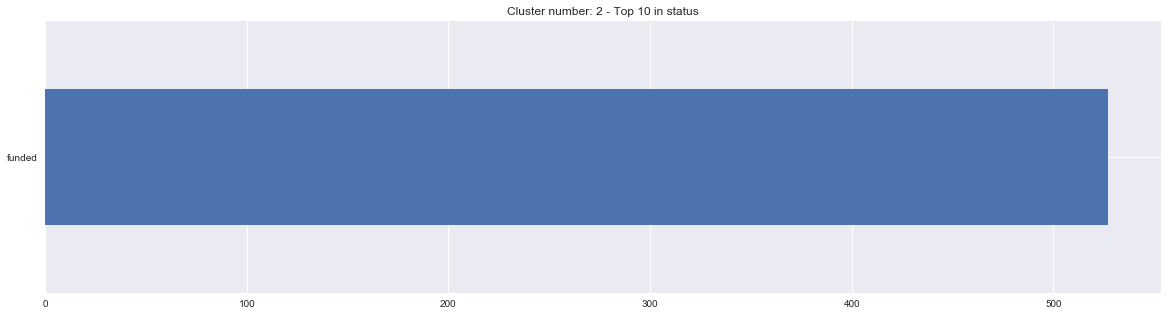

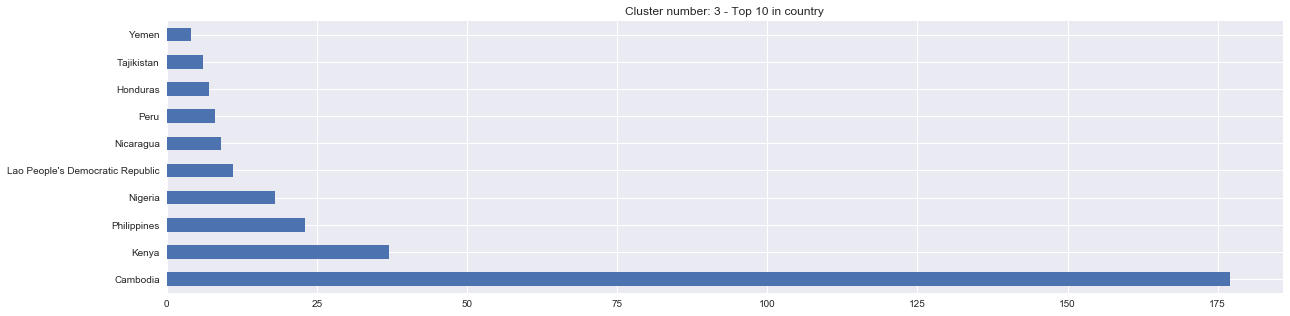

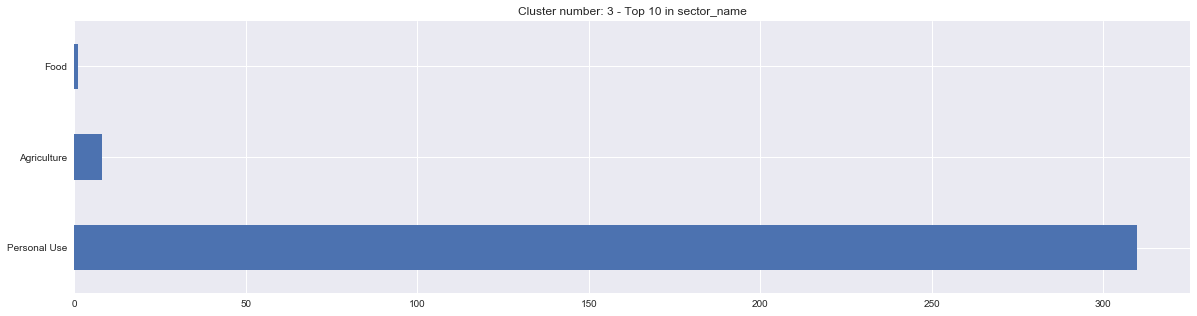

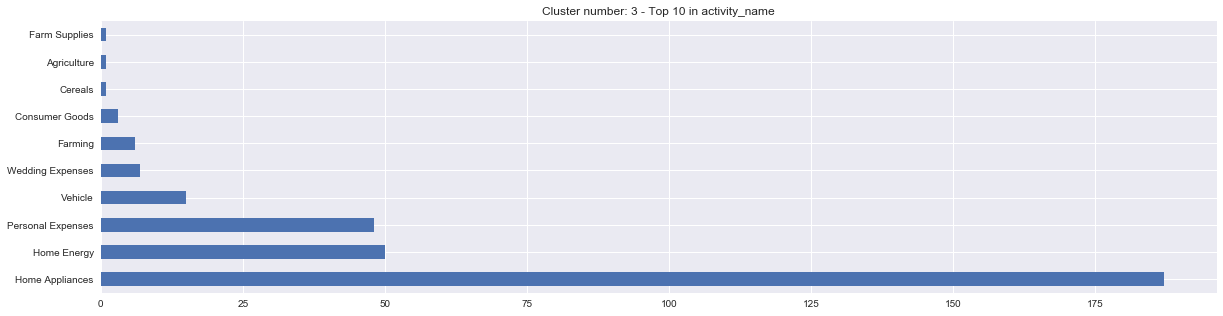

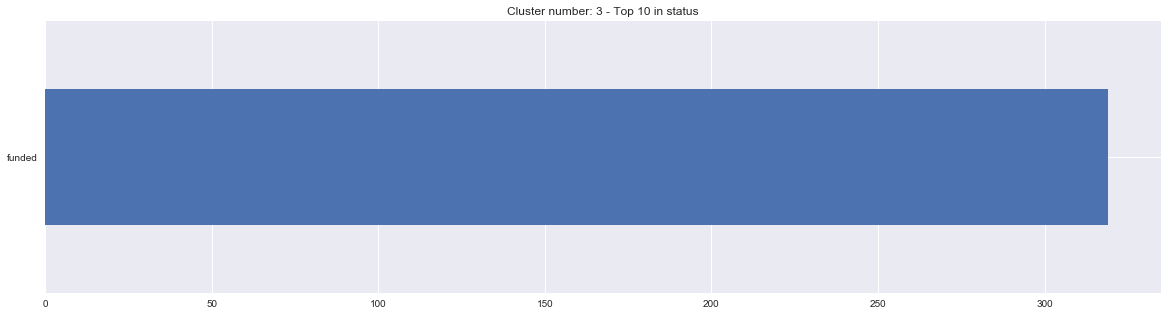


Training Sample - Numerical categorical

-----------------------------------------------


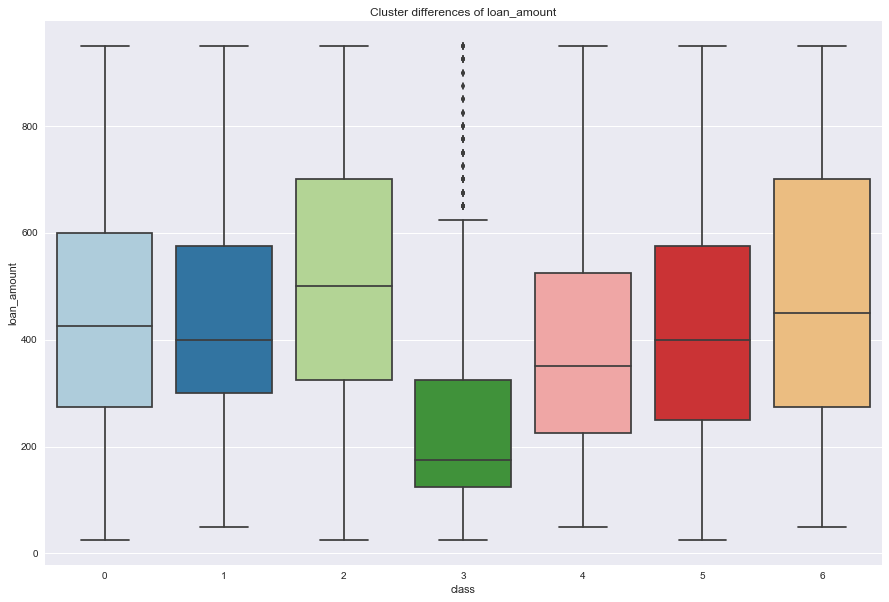

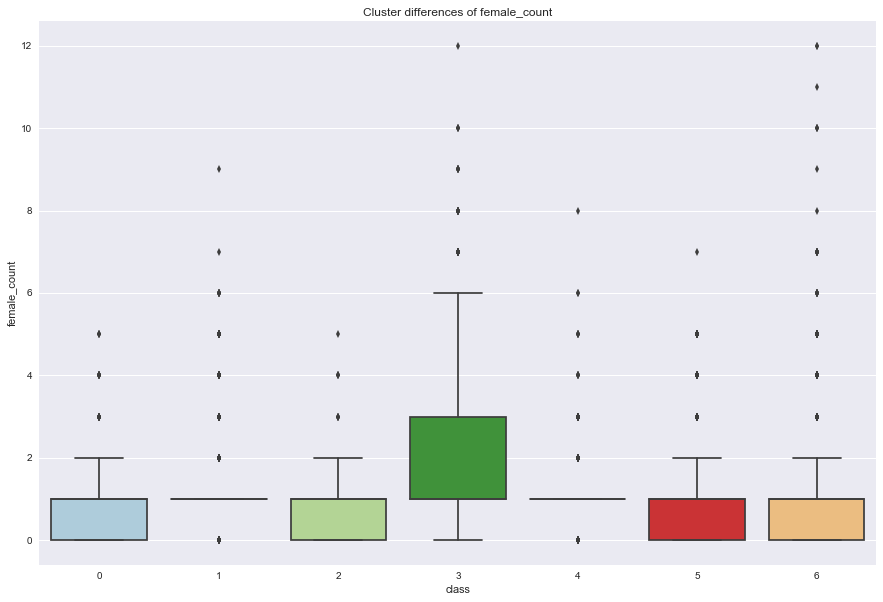

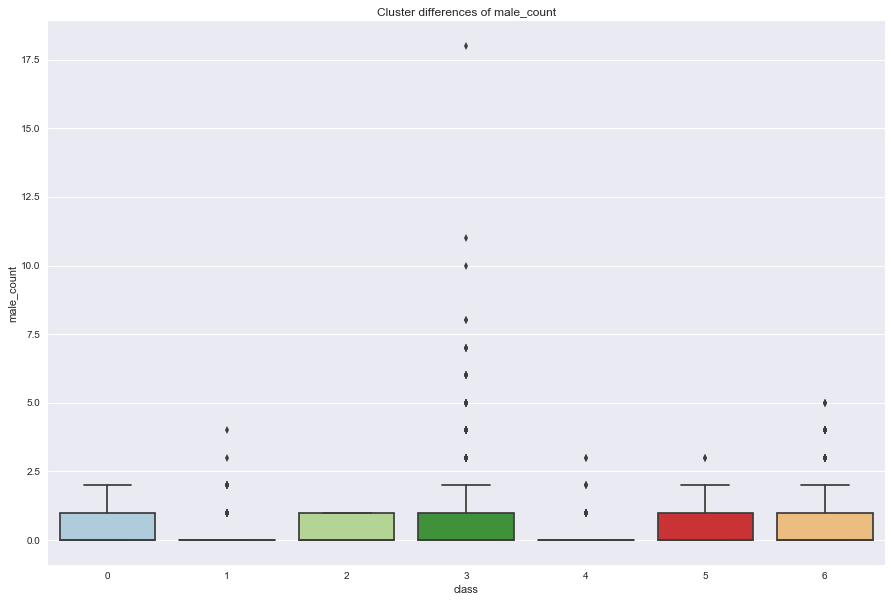

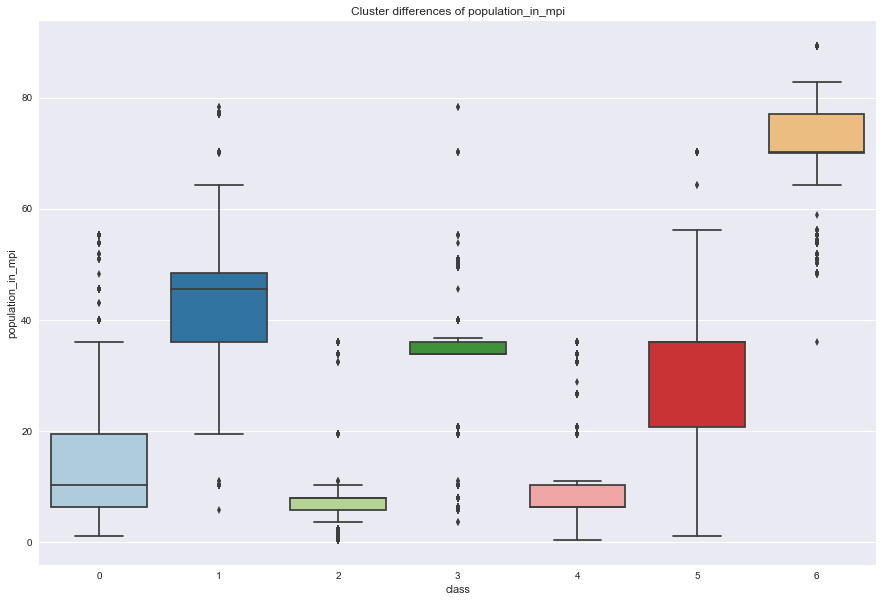

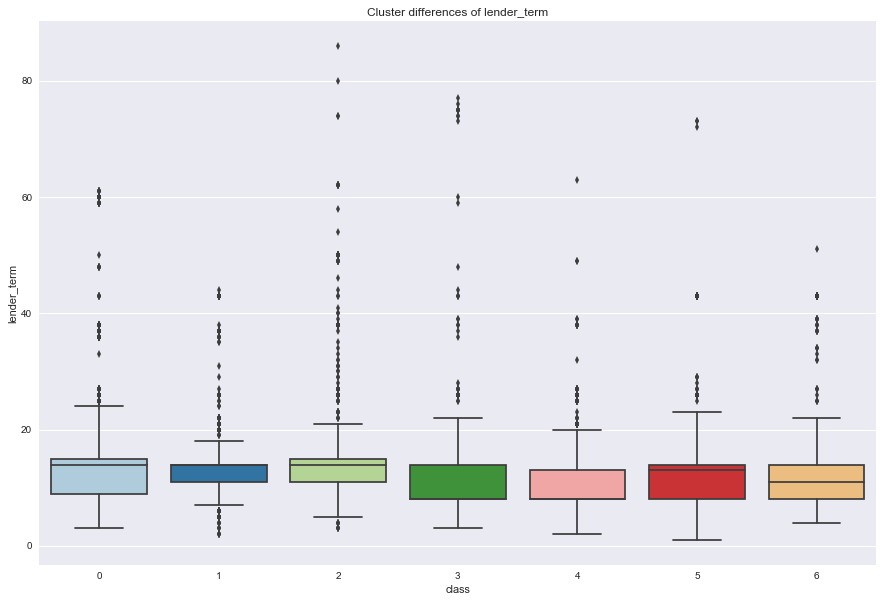

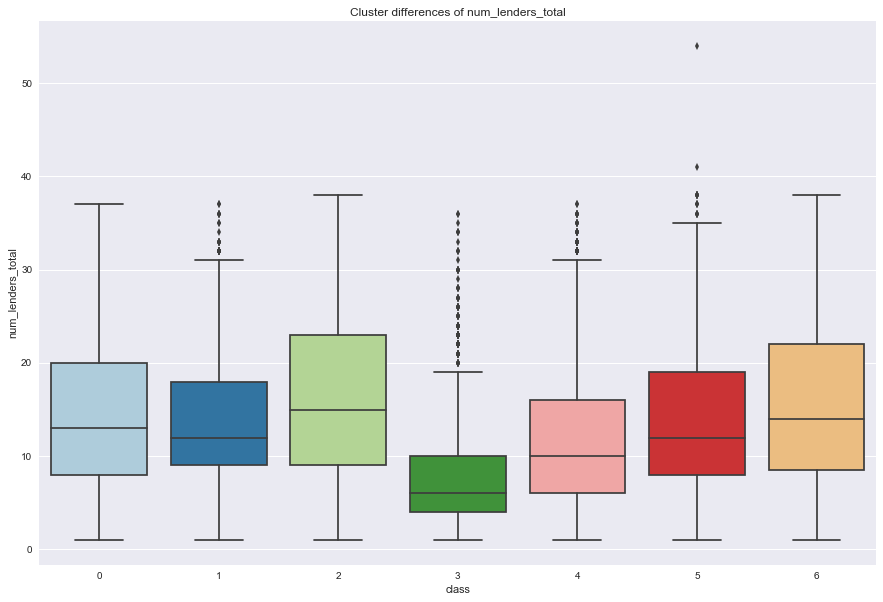

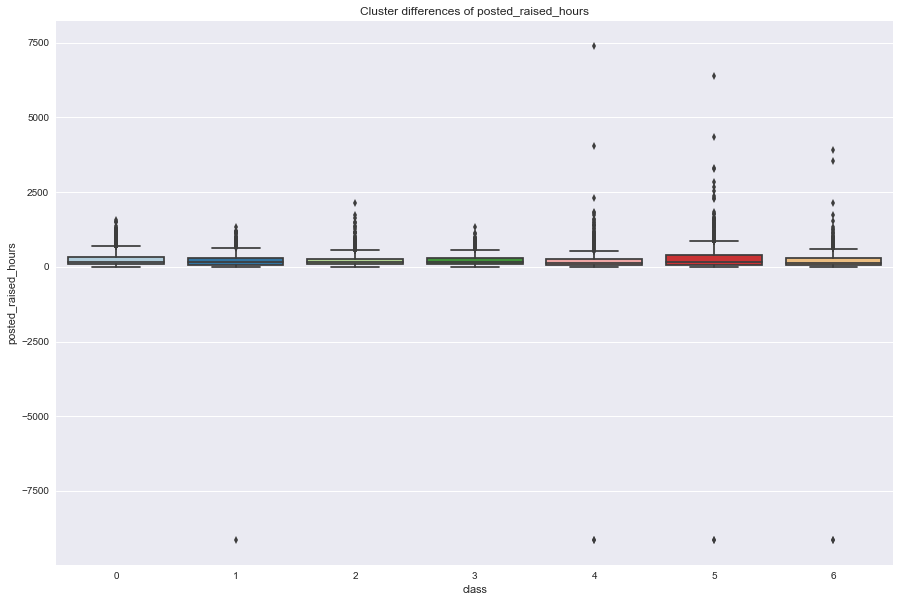

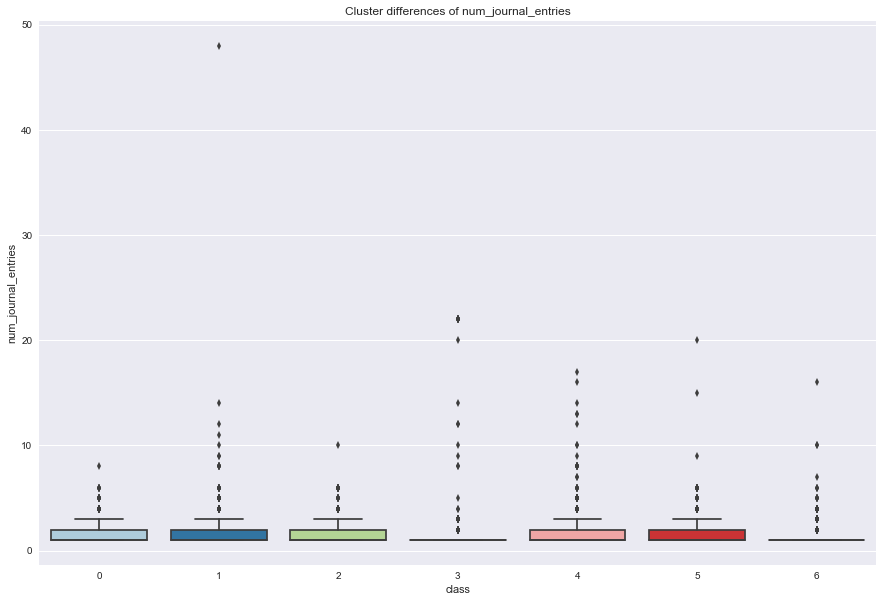


Test Sample - Numerical categorical

-----------------------------------------------


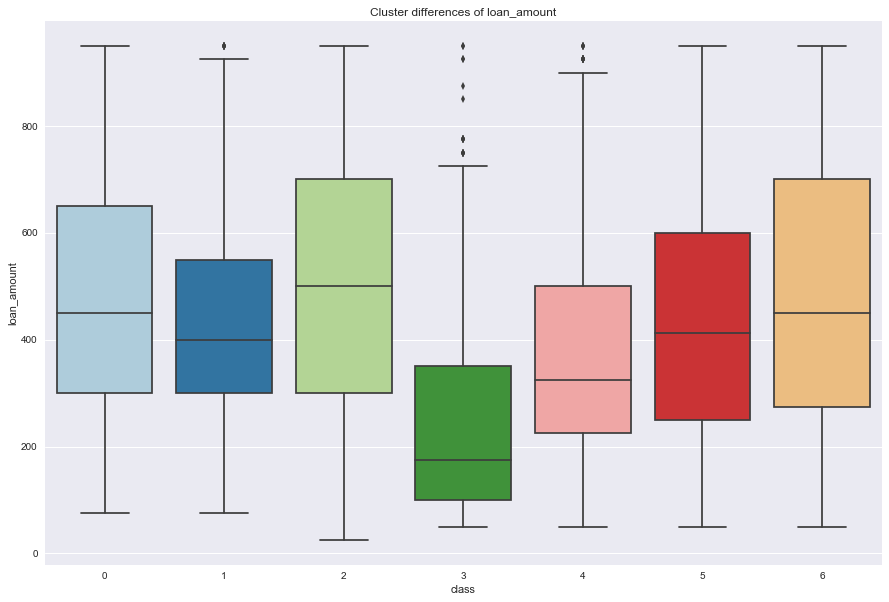

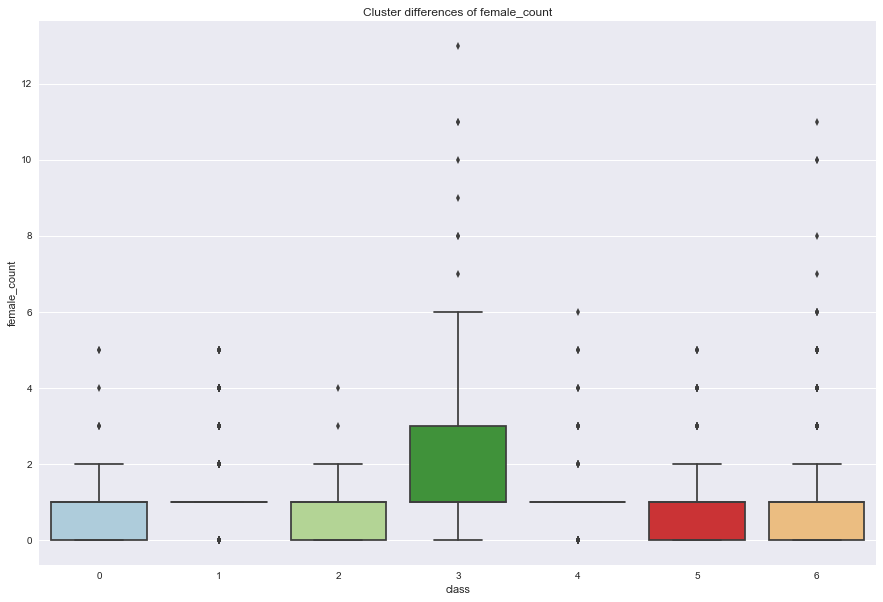

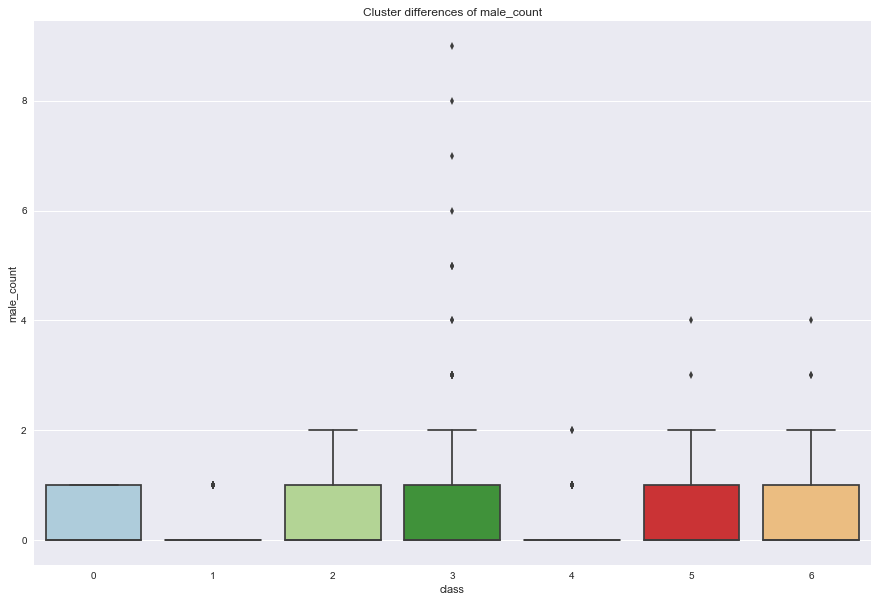

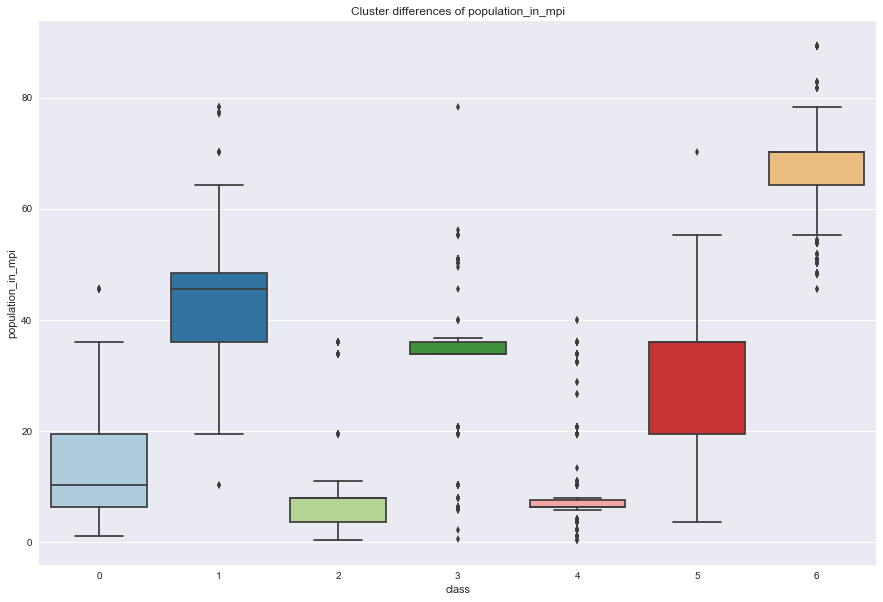

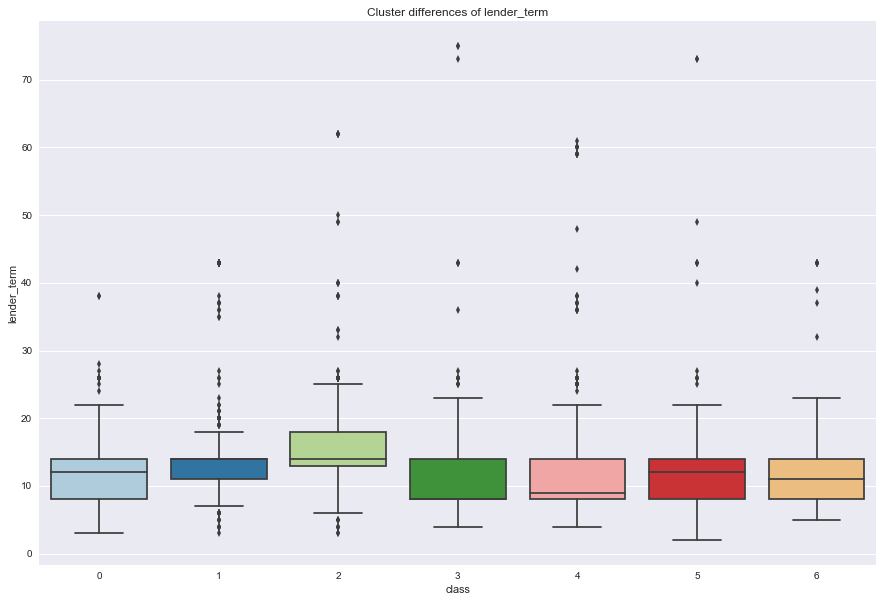

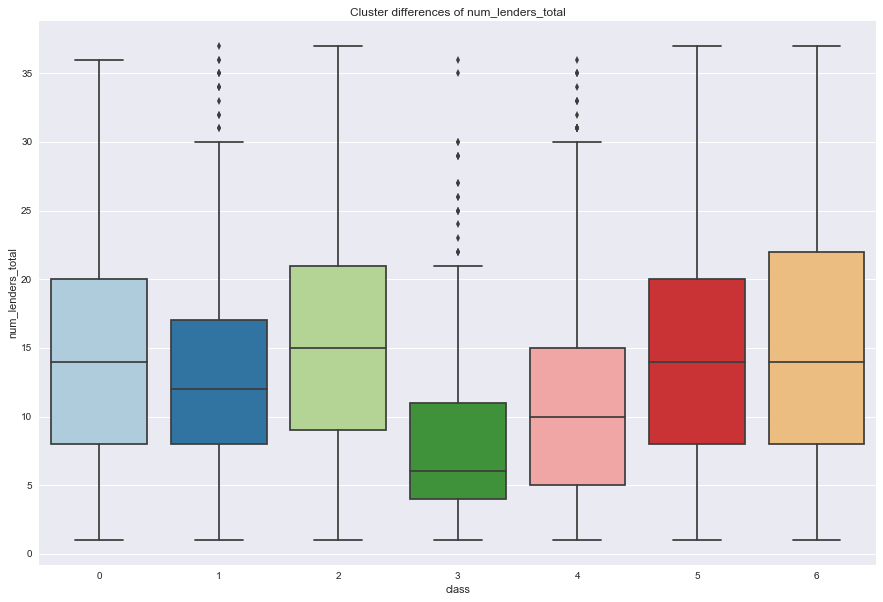

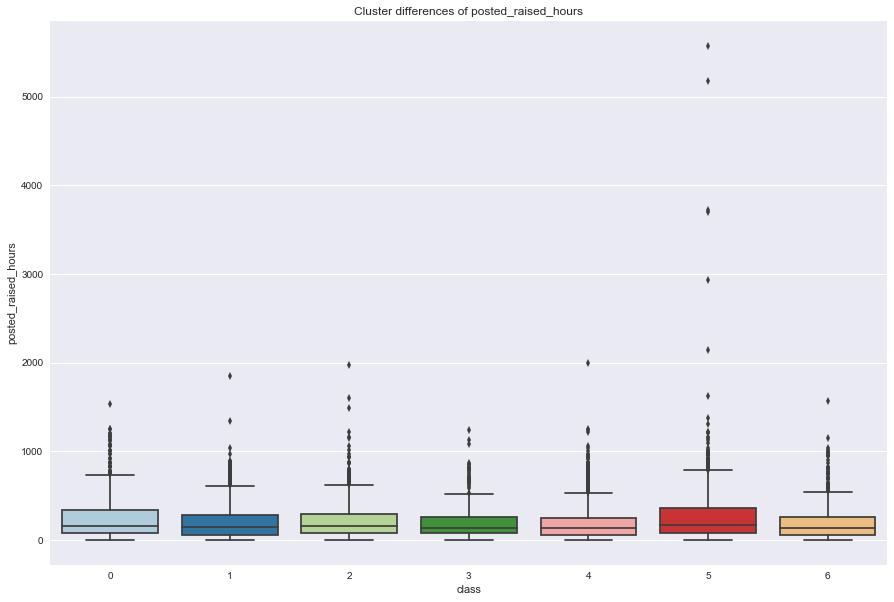

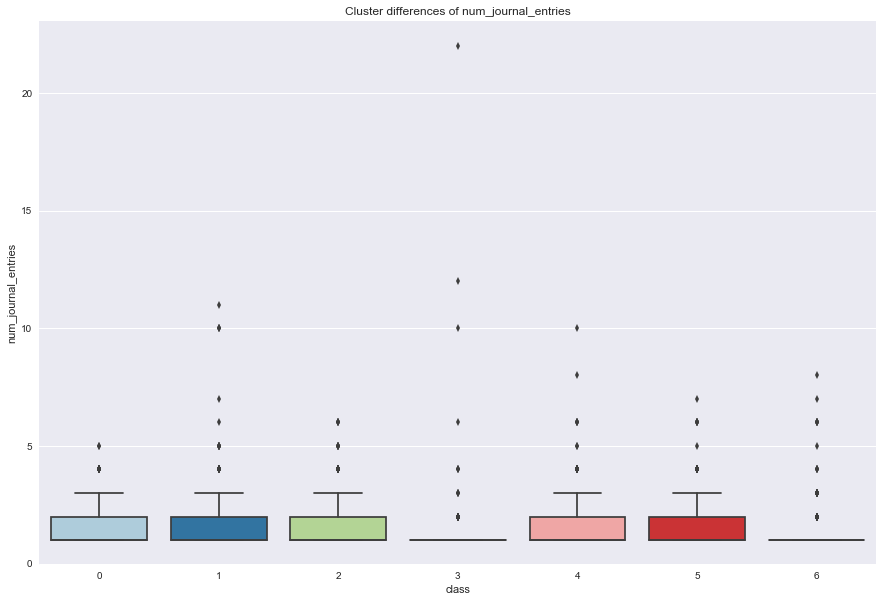

In [34]:
# Sticking with 3 component PCA to help visualize the clusters

def applyKMeansClustering(k,loan_samples):
    
    train_samples, test_samples = train_test_split(loans_samples,random_state=42)

    train_featured = getFeatureVector(train_samples)

    test_featured = getFeatureVector(test_samples)

    pca_transformed_train = applyPCA(k,train_featured)
    pca_transformed_test = applyPCA(k,test_featured)

    pca_clustered_train = pca_transformed_train
    
    pca_clustered_test = pca_transformed_test

    kmeans = KMeans(n_clusters=7, random_state=42).fit(pca_transformed_train)

    label = kmeans.labels_
    predicted = kmeans.predict(pca_transformed_test)
    
    
    pca_clustered_train['y'] = label
    
    pca_clustered_test['y'] = predicted
    
    print('\nTraining Sample')
    
    plotClusters(k,pca_clustered_train)
    
    print('\nTest Sample')
    
    plotClusters(k,pca_clustered_test)
    
    # Get train & test class info

    train_samples_clustered = train_samples
    test_samples_clustered = test_samples
    
    train_samples_clustered['class'] = label
    test_samples_clustered['class'] =  predicted
    
    print('\nTraining Sample - Describing categorical')
    
    print('\n-----------------------------------------------')
    
    plot_categorical(train_samples_clustered)
    
    
    print('\nTest Sample - Describing categorical')
    
    print('\n-----------------------------------------------')
    
    plot_categorical(test_samples_clustered)
    
    print('\nTraining Sample - Numerical categorical')
    
    print('\n-----------------------------------------------')
    
    plot_numerical(train_samples_clustered)
    
    
    print('\nTest Sample - Numerical categorical')
    
    print('\n-----------------------------------------------')
    
    plot_numerical(test_samples_clustered)
    
    list_pickle_path = f'Kiva_{k}_Clusters.pkl'
    list_pickle = open(list_pickle_path, 'wb')

    pickle.dump(kmeans, list_pickle)
    list_pickle.close()
    
    return train_samples_clustered.append(test_samples_clustered)


loan_samples_clustered = applyKMeansClustering(n_clusters,loans_samples) 

loan_samples_clustered.to_csv('Clustered_samples_dataset.csv')

In [35]:
def getLatestLoans():
    response = requests.get('http://api.kivaws.org/v1/loans/newest.json').json()
    loan_items = response['loans']

    new_loans_dictionary = []

    for loan in loan_items:
        new_item = {
            'loan_amount': loan['loan_amount'],
            'status': loan['status'],
            'activity_name': loan['activity'],
            'sector_name': loan['sector'],
            'borrower_count': loan['borrower_count'],
            'country_name': loan['location']['country'].lower()
        }

        new_loans_dictionary.append(new_item)

    new_loans_df = pd.DataFrame(new_loans_dictionary)

    new_loans_df = new_loans_df.rename(columns={'country_name':'country'})

    mpi = pd.read_csv('mpi.csv',encoding='latin-1')

    mpi_reduced = mpi[['country','mpi','population_in_mpi','Education','Health','Living standards','population_in_severe_mpi']]
    mpi_reduced.to_csv('mpi.csv',encoding='utf-8')

    merged = new_loans_df.merge(mpi_reduced,on='country')

    return merged

In [36]:
getLatestLoans()

,activity_name,borrower_count,country,loan_amount,sector_name,status,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi
0,Tailoring,1,pakistan,225,Services,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
1,Fuel/Firewood,1,pakistan,450,Retail,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
2,Wholesale,1,pakistan,275,Wholesale,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
3,Home Energy,1,kenya,100,Personal Use,fundraising,0.166,36.0,12.3,32.2,55.5,10.7
4,Farming,1,kenya,225,Agriculture,fundraising,0.166,36.0,12.3,32.2,55.5,10.7
5,Blacksmith,1,cambodia,500,Manufacturing,fundraising,0.150,33.8,30.8,26.4,42.8,11.4
6,Clothing Sales,1,ecuador,1200,Clothing,fundraising,0.015,3.7,23.6,42.4,34.0,0.5
7,Cosmetics Sales,4,nicaragua,1525,Retail,fundraising,0.088,19.4,37.8,12.6,49.6,6.9
8,Higher education costs,1,nicaragua,950,Education,fundraising,0.088,19.4,37.8,12.6,49.6,6.9
9,Fish Selling,1,nicaragua,1400,Food,fundraising,0.088,19.4,37.8,12.6,49.6,6.9


In [16]:
def describe_numerical(df):
    stats = pd.DataFrame()
        
    for k in range(n_clusters):  

        kth_cluster = df[df['class']==k]
        
        kth_stats = df[['loan_amount','female_count', 
                          'male_count','population_in_mpi',
                          'lender_term', 'num_lenders_total', 
                          'posted_raised_hours','num_journal_entries'
                       ]].describe().transpose()
        
    stats = stats.append(kth_stats)   
        
    return stats[['mean','50%']]

In [22]:
def describe_categorical(df):

    cluster_frequency = []

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        category_values = {
            str(k) : {}
        }

        for c in ['country','sector_name','activity_name','status']:
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            category_values[str(k)].update({str(c):cat_values})

        cluster_frequency.append(category_values)
        
    return cluster_frequency

In [37]:
describe_numerical(loan_samples_clustered)

,mean,50%
loan_amount,427.209421,400.0
female_count,0.925494,1.0
male_count,0.312744,0.0
population_in_mpi,25.792555,19.4
lender_term,12.536659,12.0
num_lenders_total,13.269150,12.0
posted_raised_hours,231.729717,148.0
num_journal_entries,1.496178,1.0


In [38]:
describe_categorical(loan_samples_clustered)

[{'0': {'activity_name': {'Bricks': 47,
    'Carpentry': 86,
    'Construction': 236,
    'Construction Supplies': 257,
    'Entertainment': 322,
    'Games': 343,
    'Musical Performance': 161,
    'Personal Housing Expenses': 792,
    'Property': 61,
    'Timber Sales': 47},
   'country': {'Cambodia': 172,
    'Colombia': 118,
    'Indonesia': 76,
    'Kenya': 117,
    'Mexico': 103,
    'Nicaragua': 503,
    'Pakistan': 50,
    'Peru': 382,
    'Philippines': 755,
    'Tajikistan': 61},
   'sector_name': {'Agriculture': 100,
    'Construction': 696,
    'Entertainment': 826,
    'Food': 2,
    'Housing': 853,
    'Retail': 8,
    'Transportation': 21},
   'status': {'funded': 2506}}},
 {'1': {'activity_name': {'Crafts': 93,
    'Embroidery': 252,
    'Furniture Making': 139,
    'Goods Distribution': 312,
    'Manufacturing': 209,
    'Primary/secondary school costs': 108,
    'Rickshaw': 122,
    'Tailoring': 137,
    'Weaving': 154,
    'Wholesale': 225},
   'country': {'Cambodia

In [27]:
def plot_numerical(df):
    for c in ['loan_amount','female_count', 'male_count','population_in_mpi',
              'lender_term', 'num_lenders_total', 'posted_raised_hours','num_journal_entries']:

        plt.figure(figsize=(15,10))

        sns.boxplot(x="class", y=c, data=df, palette="Paired")

        plt.title(f'Cluster differences of {c}')

        plt.savefig(f'Cluster_numerical_{c}.png')

        plt.show()
    
    stats = pd.DataFrame()

In [28]:
def plot_categorical(df):

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        for c in ['country','sector_name','activity_name','status']:
            plt.figure(figsize=(20,5))
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            kth_cluster[c].value_counts().head(10).plot(kind='barh')
            
            plt.title(f'Cluster number: {k} - Top 10 in {c}')
            plt.savefig(f'cluster_category_{c}.png')
            plt.show()            
        

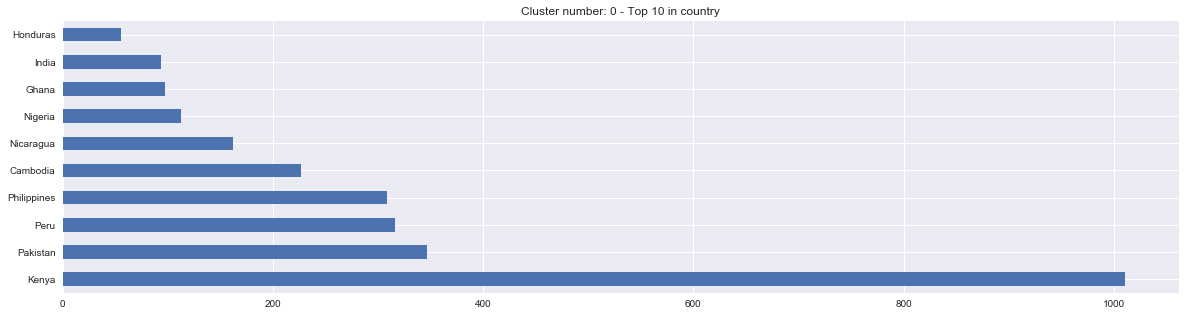

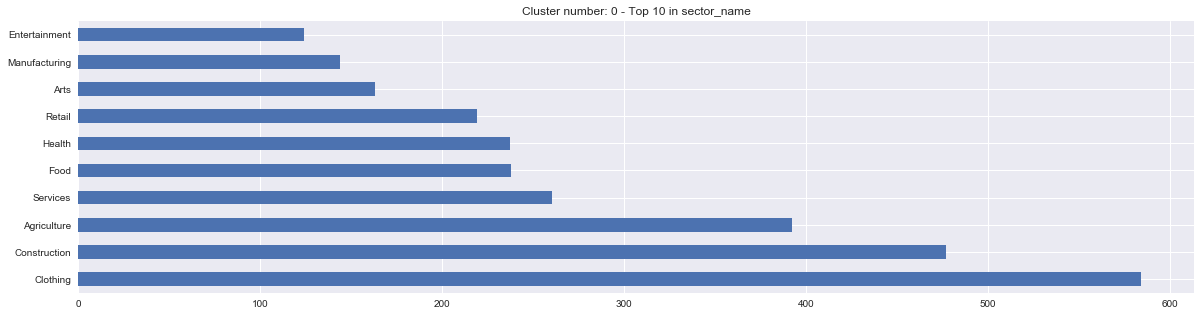

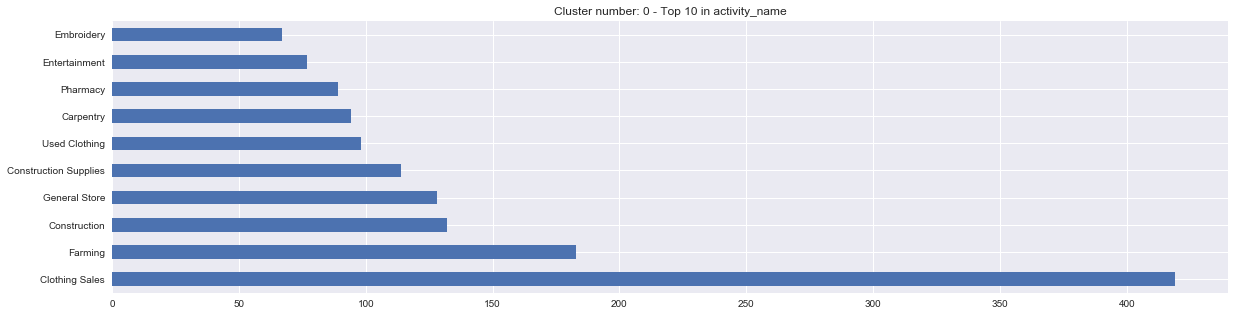

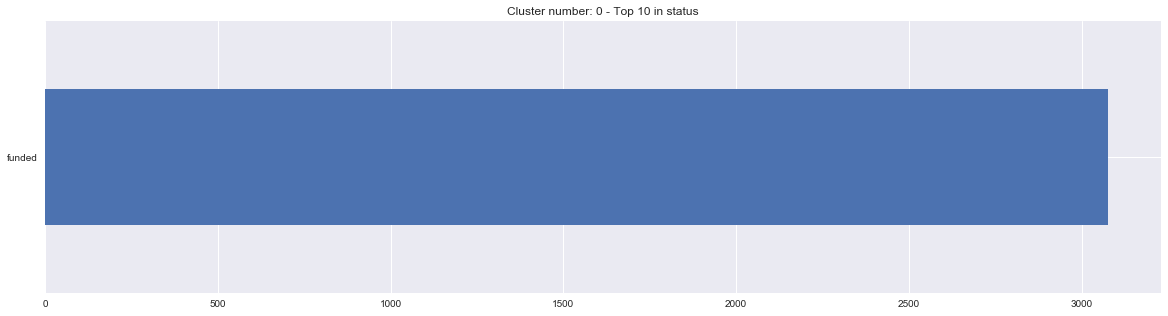

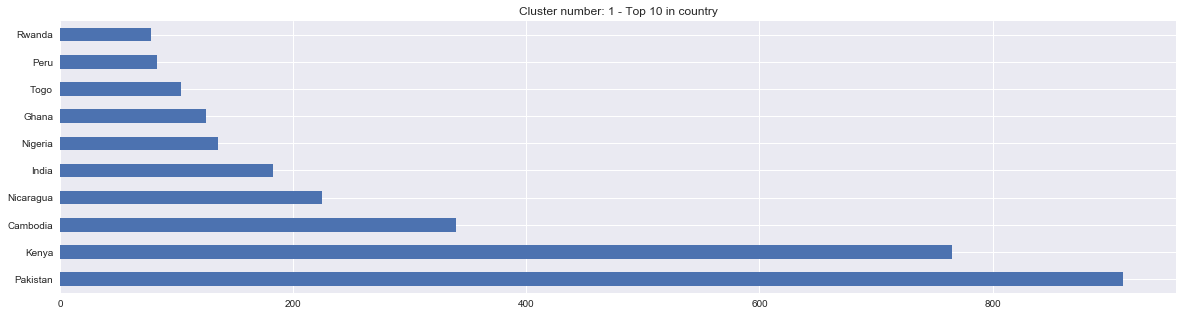

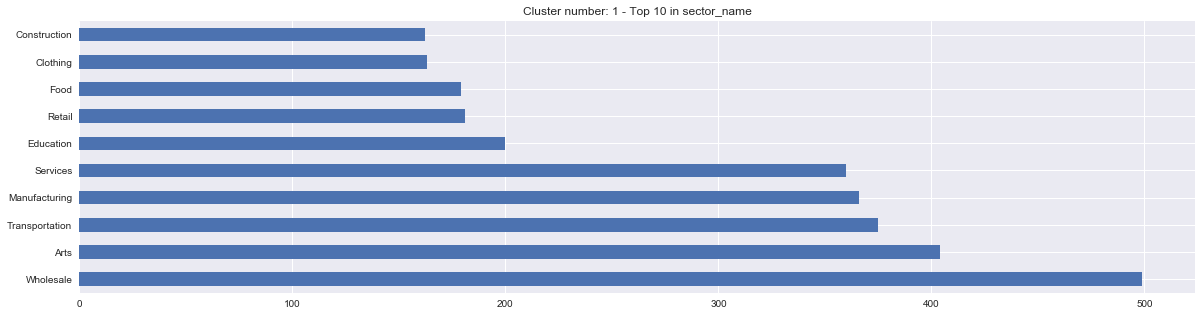

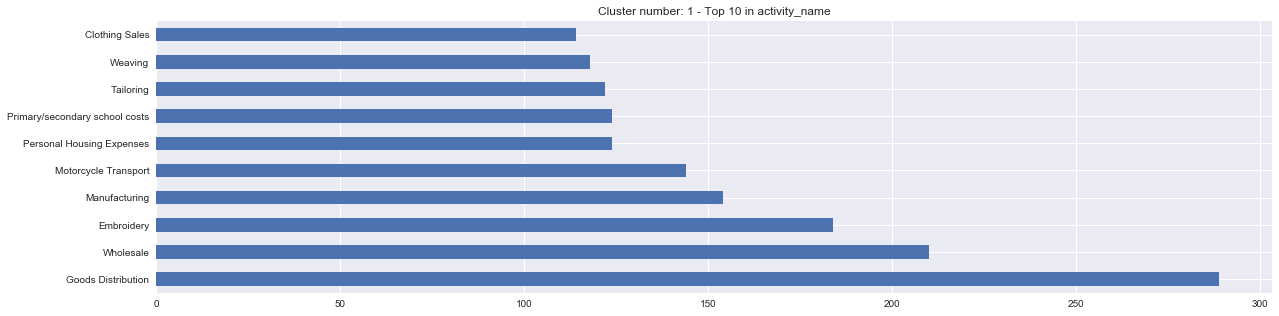

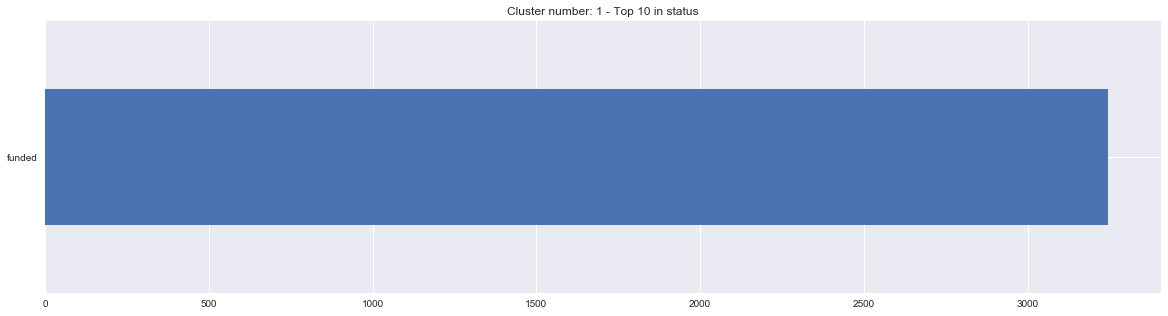

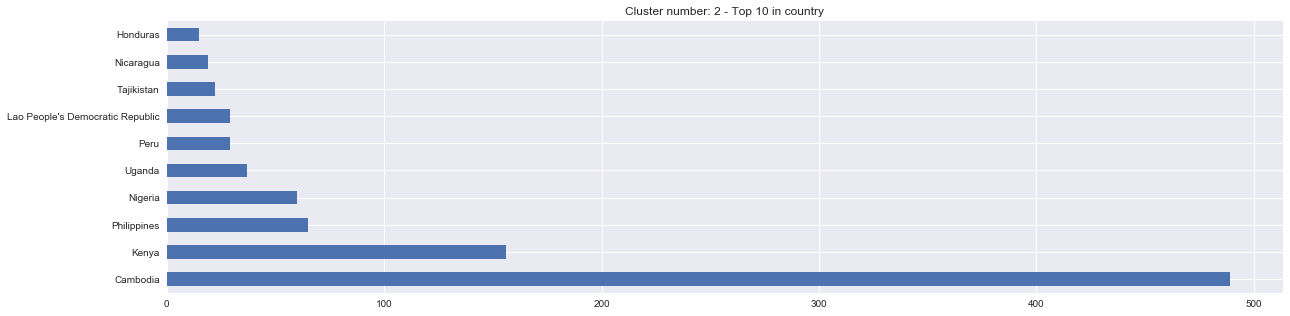

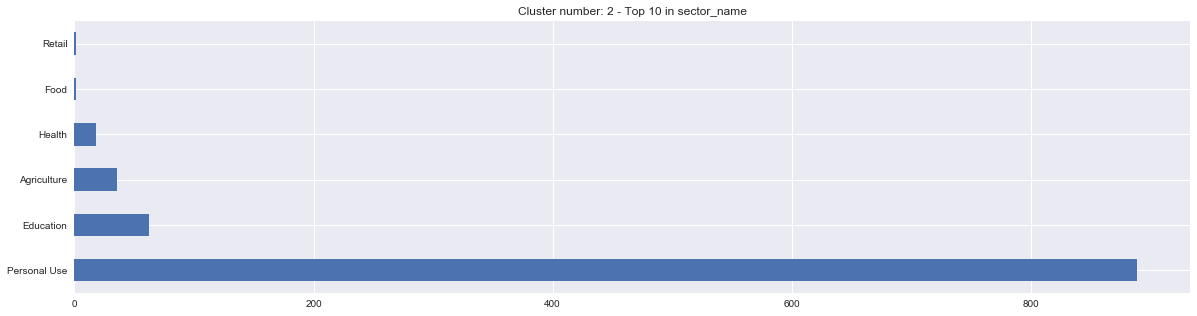

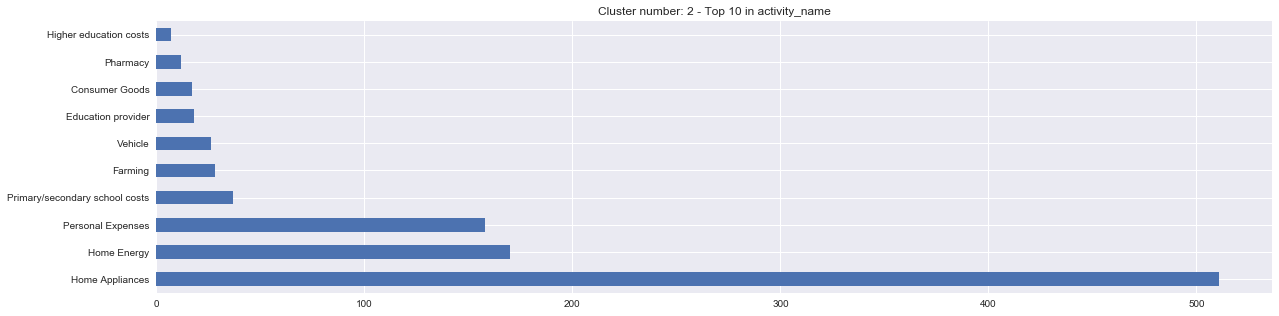

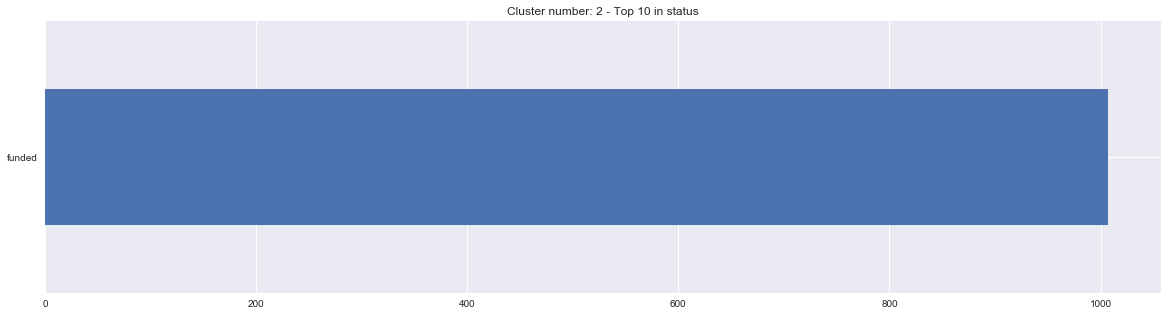

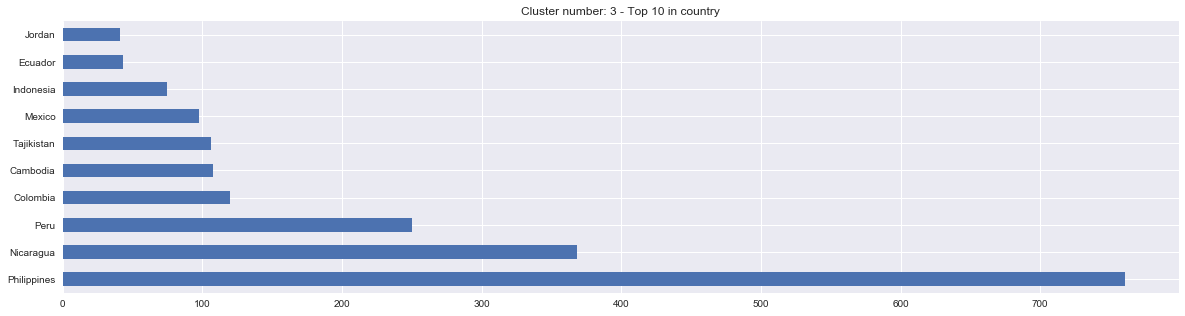

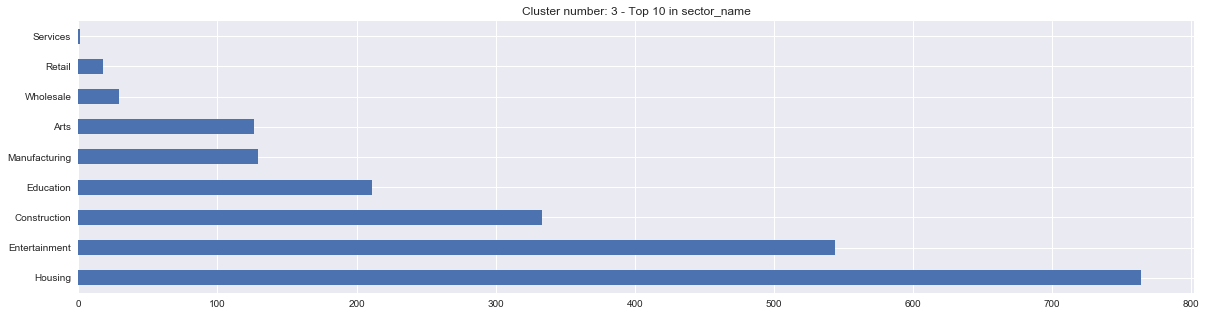

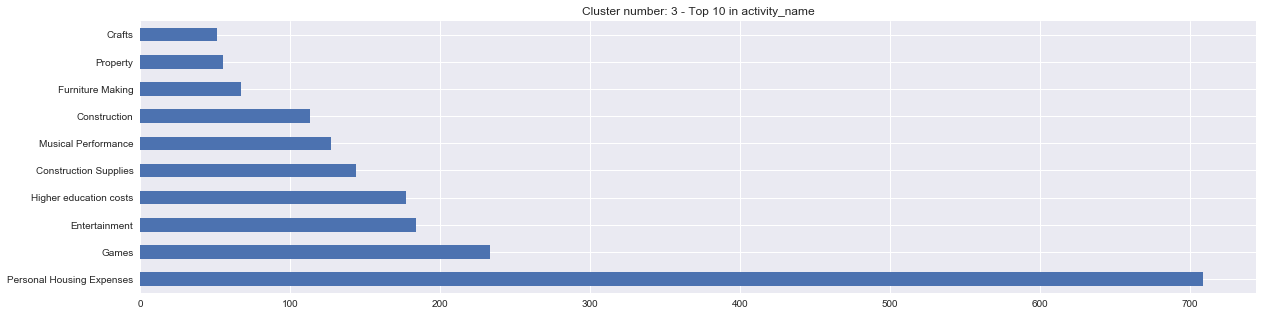

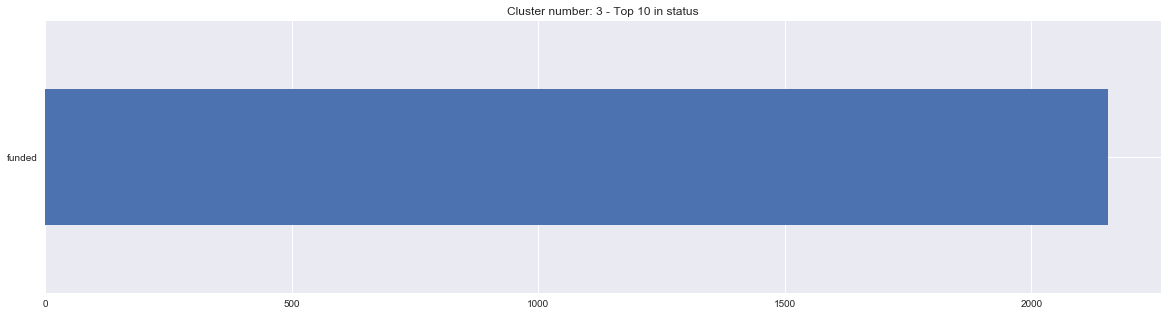

In [29]:
plot_categorical(loan_samples_clustered)

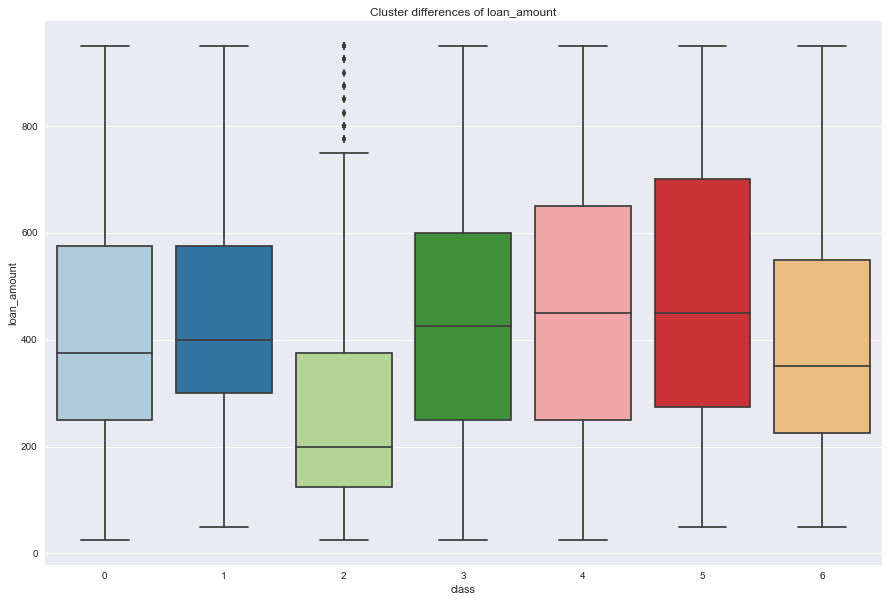

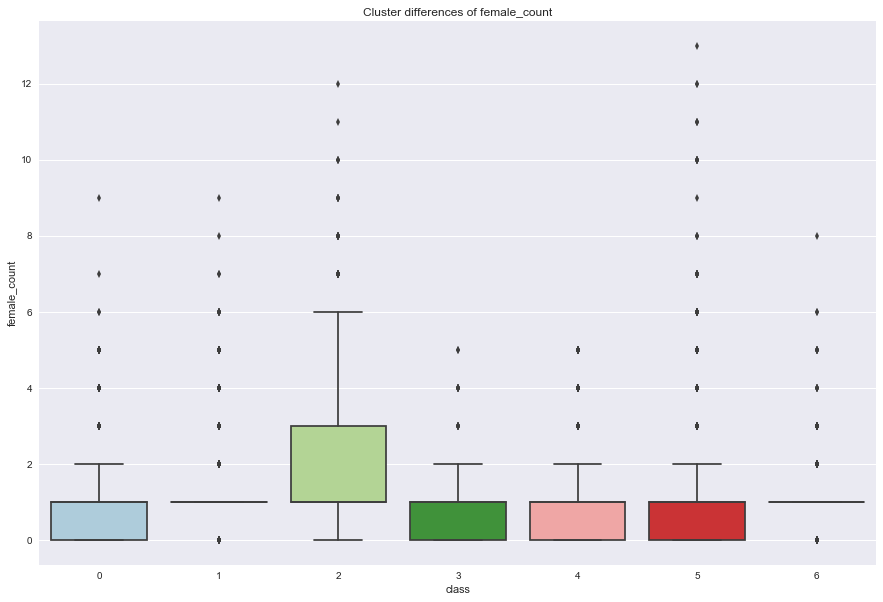

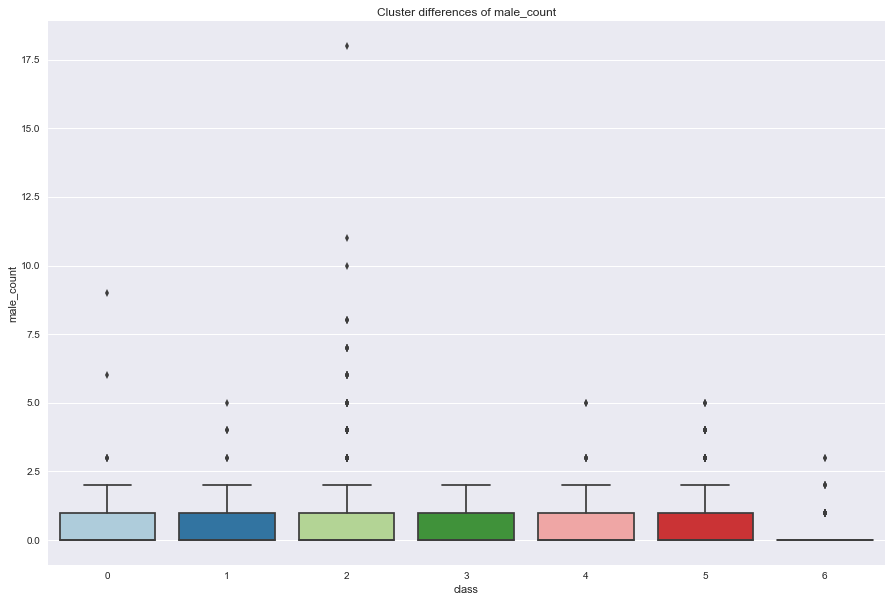

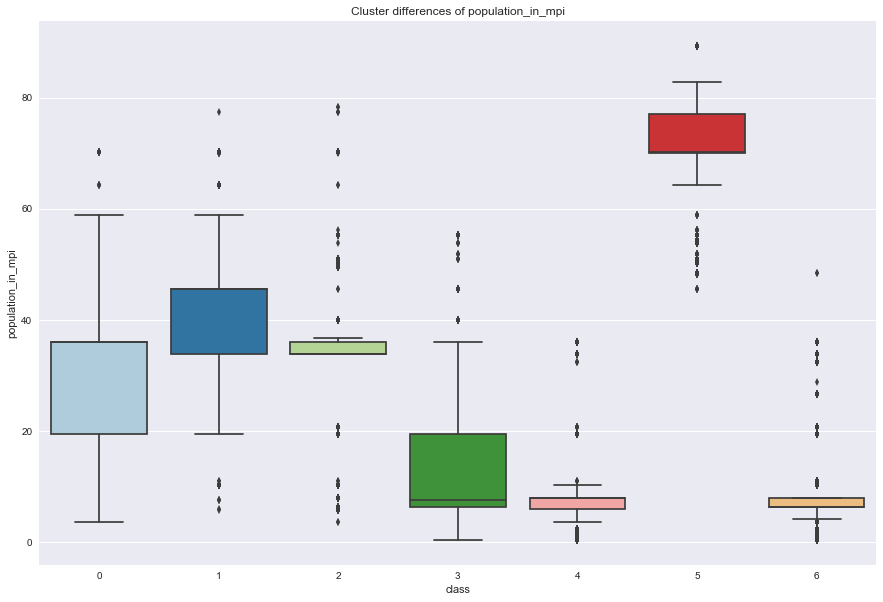

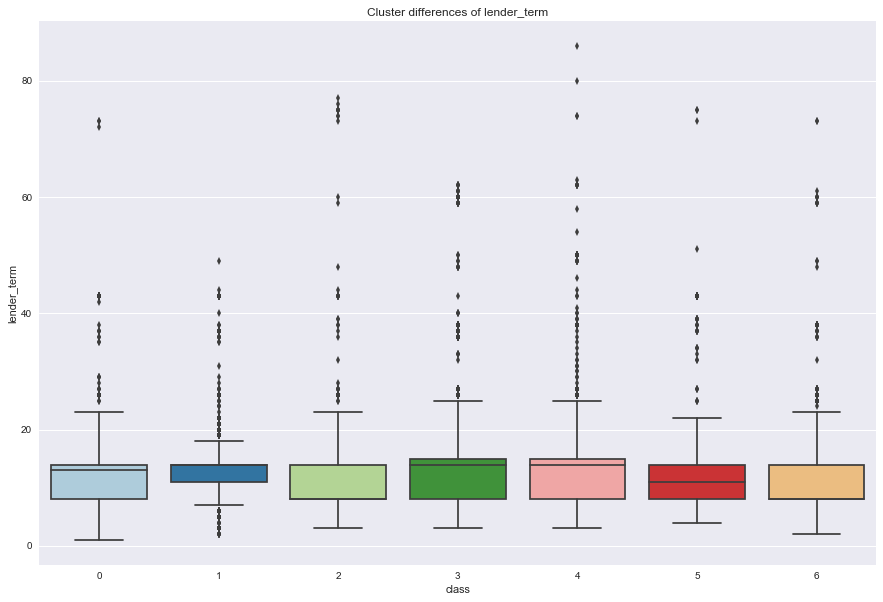

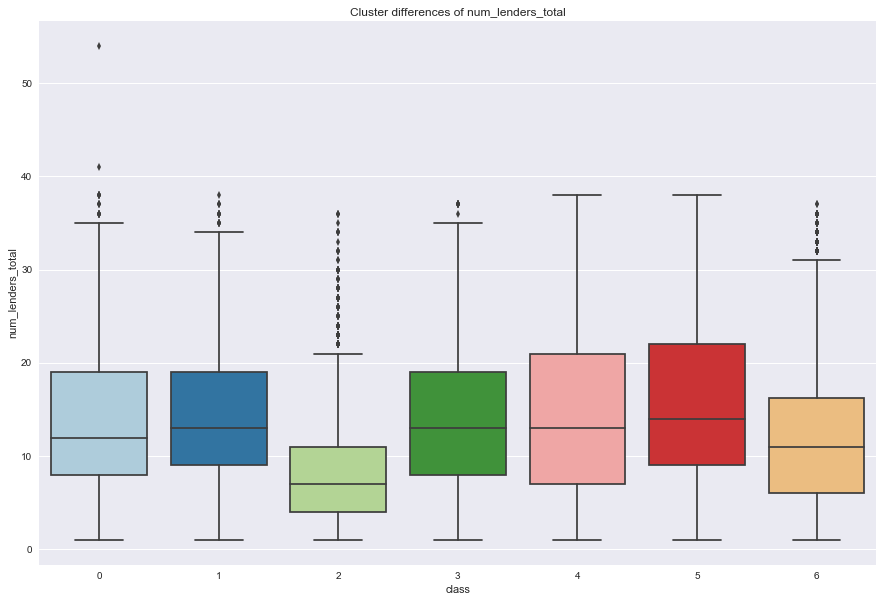

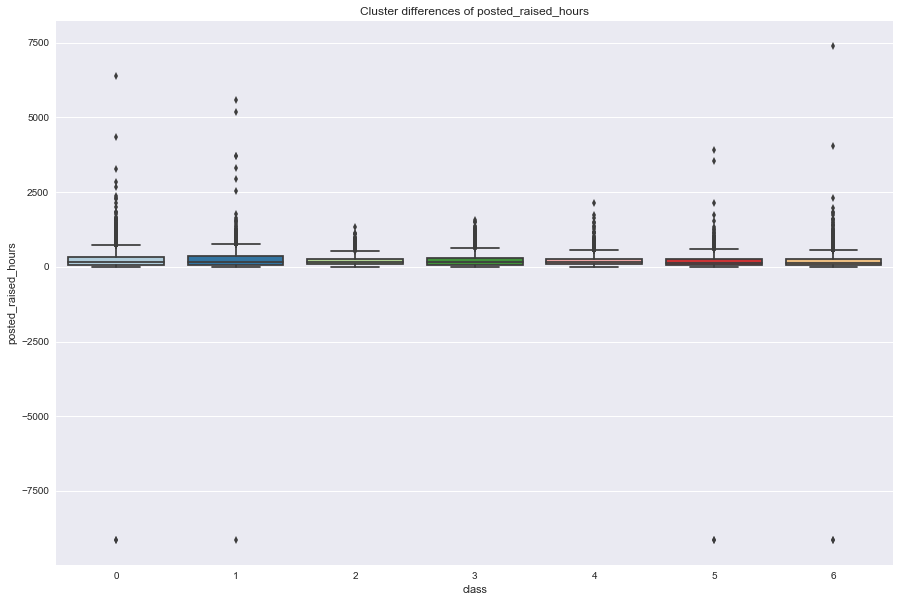

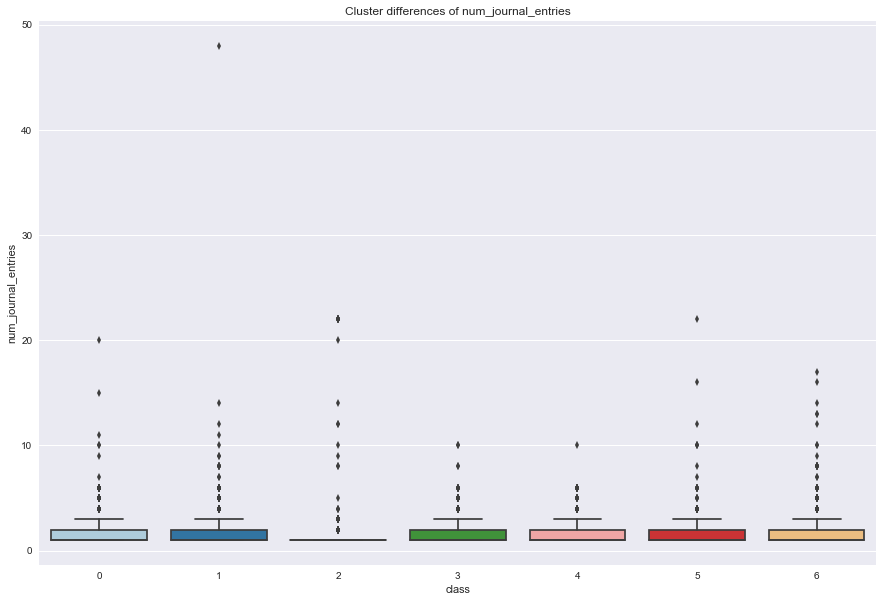

In [30]:
plot_numerical(loan_samples_clustered)

In [39]:
merged_ds = getLatestLoans()

In [40]:
getFeatureVector(merged_ds)

,loan_amount,borrower_count,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi,status_fundraising,activity_name_Blacksmith,...,activity_name_Wholesale,sector_name_Agriculture,sector_name_Clothing,sector_name_Education,sector_name_Food,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Wholesale
0,-0.823624,-0.377964,1.637080,1.510591,0.849398,-0.140997,-0.610847,1.908016,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,-0.258199,-0.377964,-0.258199,-0.258199,-0.577350,2.081666,-0.258199
1,-0.535055,-0.377964,1.637080,1.510591,0.849398,-0.140997,-0.610847,1.908016,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,-0.258199,-0.377964,-0.258199,-0.258199,1.732051,-0.480384,-0.258199
2,-0.759498,-0.377964,1.637080,1.510591,0.849398,-0.140997,-0.610847,1.908016,0.0,-0.258199,...,3.872983,-0.377964,-0.258199,-0.258199,-0.377964,-0.258199,-0.258199,-0.577350,-0.480384,3.872983
3,-0.983940,-0.377964,0.781642,0.918837,-1.423589,-0.147388,1.584529,0.181651,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,-0.258199,-0.377964,-0.258199,3.872983,-0.577350,-0.480384,-0.258199
4,-0.823624,-0.377964,0.781642,0.918837,-1.423589,-0.147388,1.584529,0.181651,0.0,-0.258199,...,-0.258199,2.645751,-0.258199,-0.258199,-0.377964,-0.258199,-0.258199,-0.577350,-0.480384,-0.258199
5,-0.470929,-0.377964,0.588867,0.783227,0.335836,-0.518054,0.417948,0.258135,0.0,3.872983,...,-0.258199,-0.377964,-0.258199,-0.258199,-0.377964,3.872983,-0.258199,-0.577350,-0.480384,-0.258199
6,0.426842,-0.377964,-1.037671,-1.072169,-0.348913,0.504473,-0.390391,-0.932838,0.0,-0.258199,...,-0.258199,-0.377964,3.872983,-0.258199,-0.377964,-0.258199,-0.258199,-0.577350,-0.480384,-0.258199
7,0.843664,2.645751,-0.158136,-0.104405,1.001565,-1.399984,1.042574,-0.233551,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,-0.258199,-0.377964,-0.258199,-0.258199,1.732051,-0.480384,-0.258199
8,0.106209,-0.377964,-0.158136,-0.104405,1.001565,-1.399984,1.042574,-0.233551,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,3.872983,-0.377964,-0.258199,-0.258199,-0.577350,-0.480384,-0.258199
9,0.683348,-0.377964,-0.158136,-0.104405,1.001565,-1.399984,1.042574,-0.233551,0.0,-0.258199,...,-0.258199,-0.377964,-0.258199,-0.258199,2.645751,-0.258199,-0.258199,-0.577350,-0.480384,-0.258199
